This file is derived from `TESQ-ml-ns_on_nogo_go`. This version doesn't use z-scoring at any point except what has already been done by SPM when betas were extracted.

This follows Elliot's idea for a contrast:

> **proposal 1**
> 
> Two class (e.g., CorrectStop vs. CorrectGo)
> 
> Leave-One-Out classifier...
> 
> Neural similarity of a subject to the group with a Stop vs. Go contrast might actually be indicative of performance.
> 
> subjects will naturally differ across the task as to how much their average signal responds to that, and the ones with better response might have better response inhibition.

So there are a couple of steps here...

1. iterate through subjects, holding out one at a time, and do the following steps.
2. Train a classifier across all the training subjects, classifying Stop vs. Go. We can start with the beta averages since those have done so well.
3. Use that classifier as a 'neural signature' to measure Stop. No real need to go to the betaseries--just see the extent to which each subject's Stop response matches the group's.
    - DASA: How about instead of this, we use the classifier as a classifier to do LOOCV, and measure the confidence of classifying go vs. stop for each subject rather than trying to use the classifier as a neural signature.
4. After you've iterated through all subjects, you have a measure of response inhibition for each subject. See if that regresses onto SST_SSRT or any of our other measures of response inhibition.




As a first pass, we can simplify this a bit just trying that single classifier on all subjects. This means that we're using train for tes tset but it will give us an initial measure of feasibility.

We probably do need to restrict to a specific brain region though, and that means retraining. - I think that prefrontal cortex mask we have works well.

## Data already generated

Can we use data already generated in `SST_inhibition_cv.ipynb`?

In [1]:
import pickle
from IPython.core.display import display, HTML, Markdown

In [2]:
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [3]:
from nilearn import plotting
from nilearn.masking import compute_brain_mask
import nltools as nlt

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


Not quite--we need a PFC mask I think. But we can use the script already written to do that.

## Setup

In [32]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

from os import path



## 2-class classification with PFC mask

In [33]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)

(8, 238955)
2


In [34]:

def condition_resp_trans_func(X):
    return(X.condition_label)


In [35]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_58subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

In [36]:
#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_pfcmask.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

In [37]:
from analyze_results import *

In [38]:

def remove_selected_outliers_tesq_study(ind_div_combined,show_plot=False):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy','CS_trials_CS_similarity','CG_trials_CG_similarity',
     'cancer_promoting_minus_preventing_FFQ','bf_1'],
    show_plot=show_plot)
    return(idc_outliers_removed)

### PFC (repeated)

Repeat the PFC analysis above using a more automated pipeline that can be re-applied to other masks.

In [54]:

dataset_name = 'conditions'


brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function
results_filepath=ml_data_folderpath + "/SST/train_test_res_nozscore_" + dataset_name + "_84subs_twoclasses_pfcmask.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)
relevant_mask = pfc_mask



(8, 238955)
2


In [55]:
raw_data=pickle.load(open(brain_data_filepath,'rb'))

In [56]:
raw_data.X

condition_index condition_label  \
0                 0       CorrectGo   
1                 1     CorrectStop   
0                 0       CorrectGo   
1                 1     CorrectStop   
0                 0       CorrectGo   
..              ...             ...   
1                 1     CorrectStop   
0                 0       CorrectGo   
1                 1     CorrectStop   
0                 0       CorrectGo   
1                 1     CorrectStop   

                             raw_beta_description           beta subject  wave  
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV005     1  
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV005     1  
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV006     1  
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV006     1  
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV010     1  
..                                            ...            ...     ...   ...  
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV216     1  
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV217     1  
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV217     1  
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV218     1  
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV218     1  

[162 rows x 6 columns]

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_pfcmask.pkl
0.7283950617283951


### correct_stop_ns

### correct_go_ns

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_pfcmask.pkl
plotting signatures


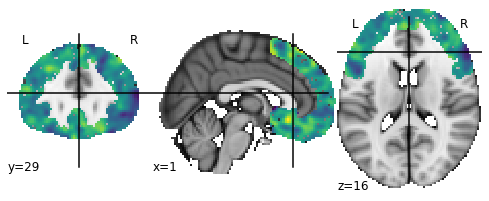

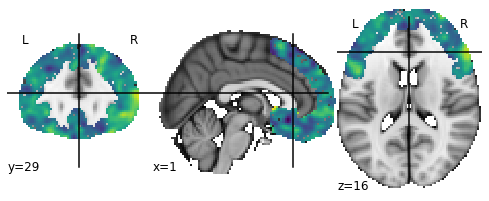

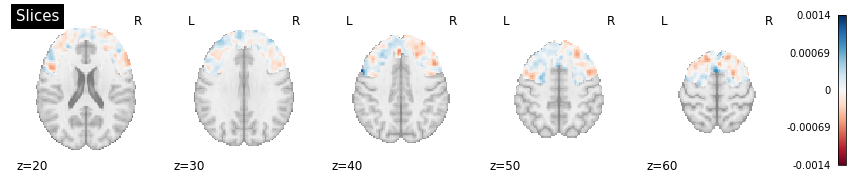

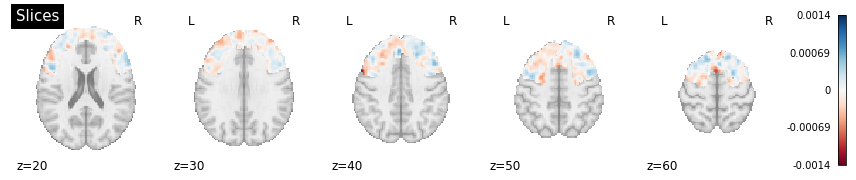

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


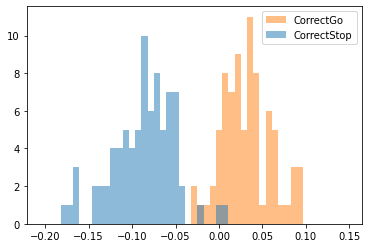

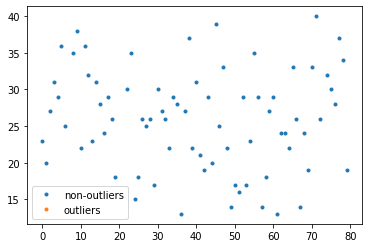

76 , 76


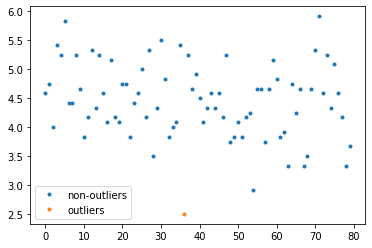

80 , 79


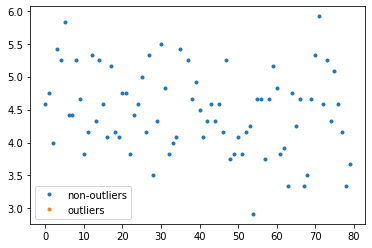

79 , 79


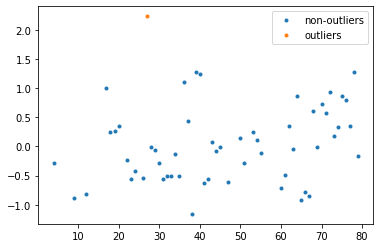

56 , 55


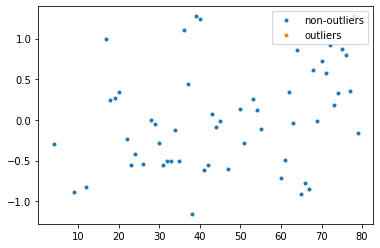

55 , 55


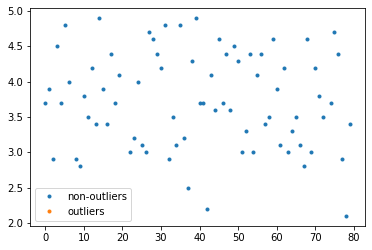

76 , 76


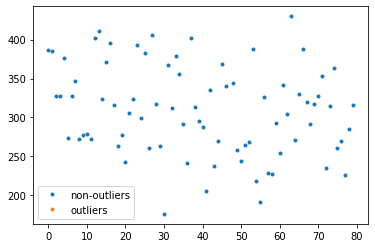

79 , 79


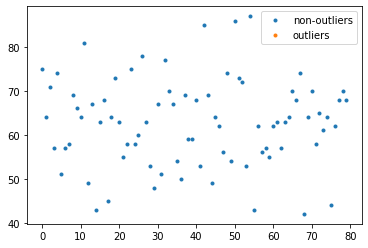

80 , 80


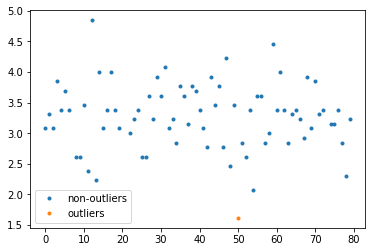

76 , 75


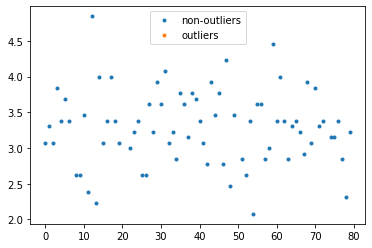

75 , 75


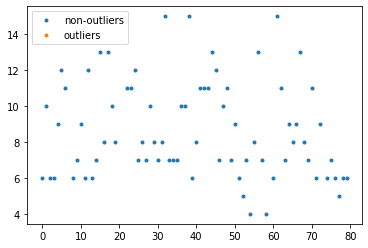

75 , 75


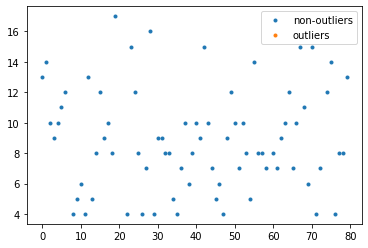

75 , 75


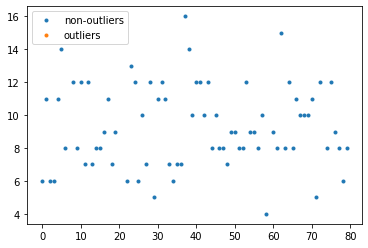

75 , 75


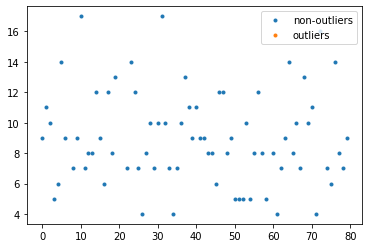

75 , 75


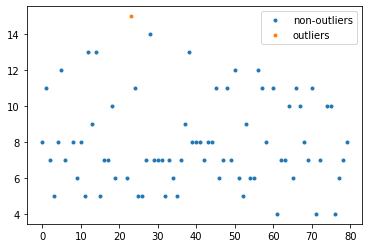

75 , 74


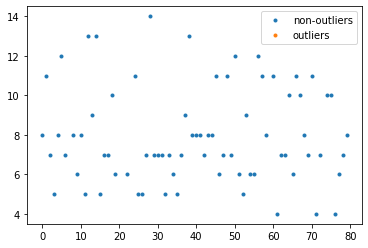

74 , 74


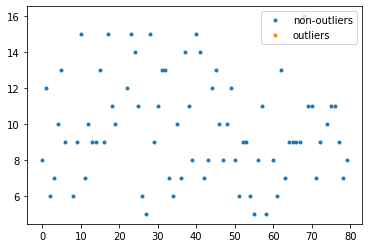

75 , 75


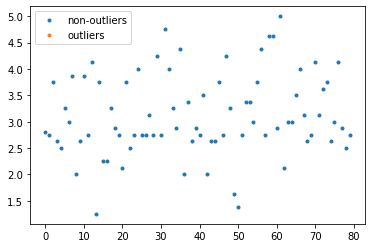

80 , 80


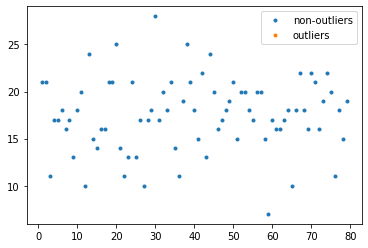

79 , 79


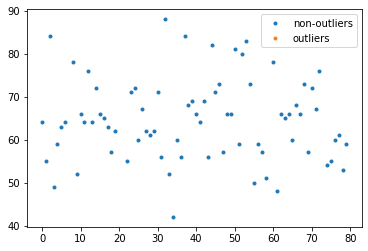

75 , 75


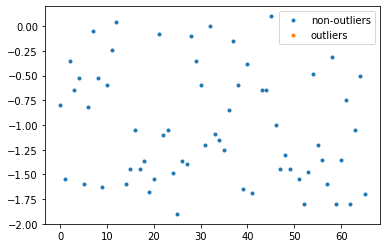

63 , 63


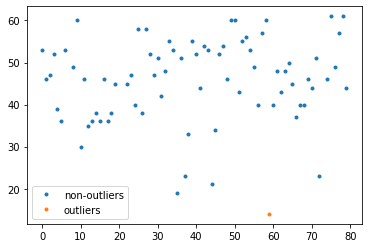

76 , 75


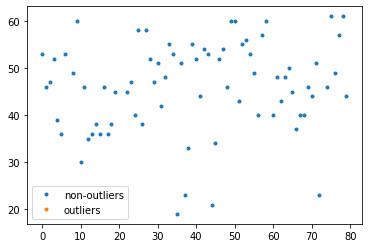

75 , 75


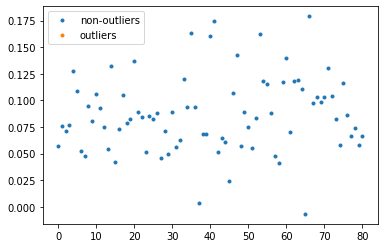

81 , 81


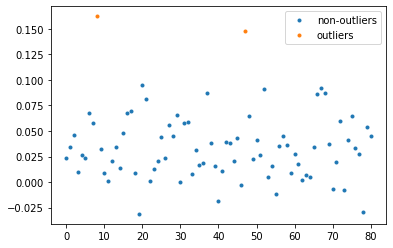

81 , 79


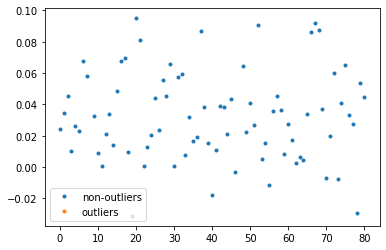

79 , 79


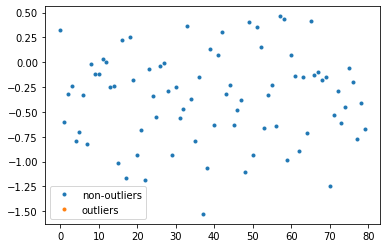

80 , 80


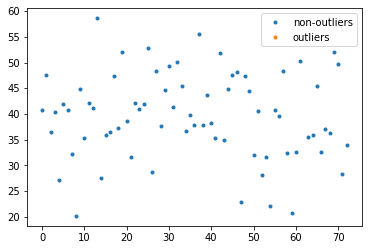

72 , 72


### CS_trials_CS_similarity

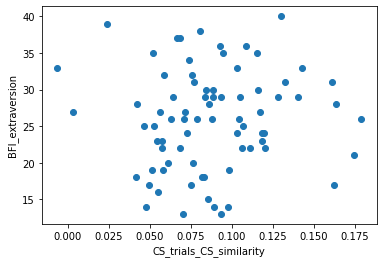

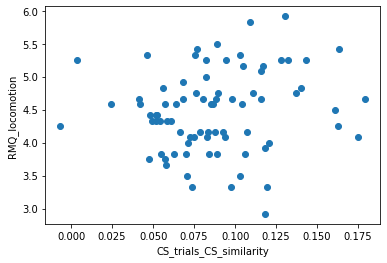

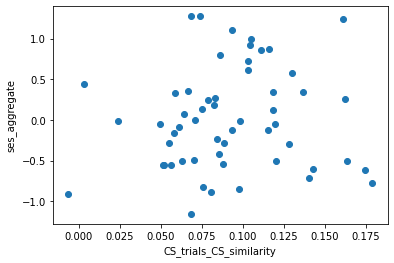

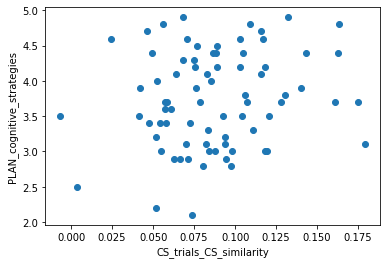

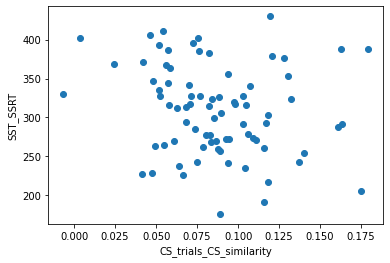

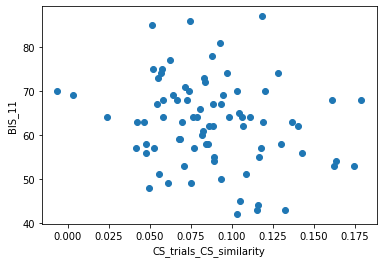

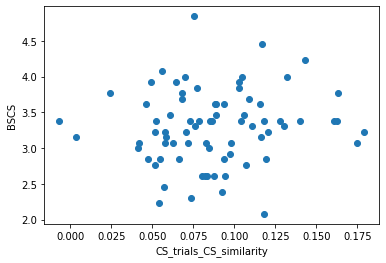

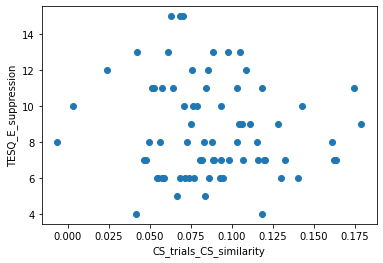

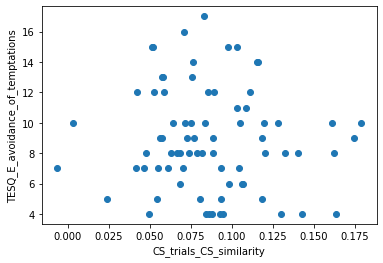

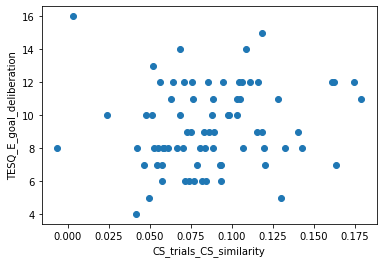

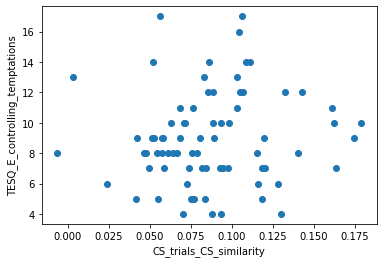

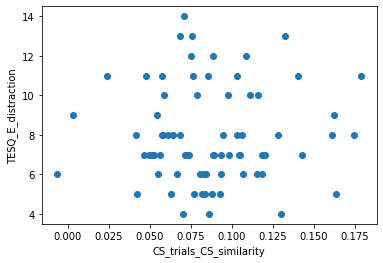

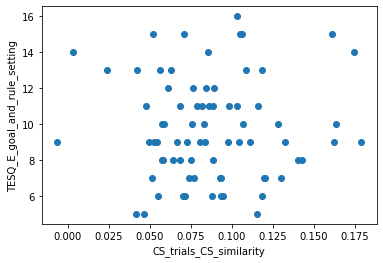

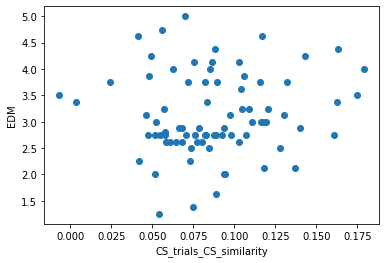

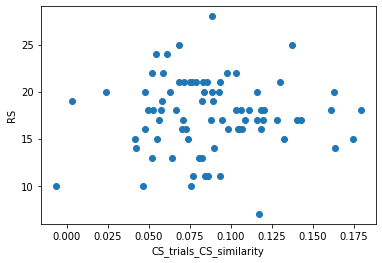

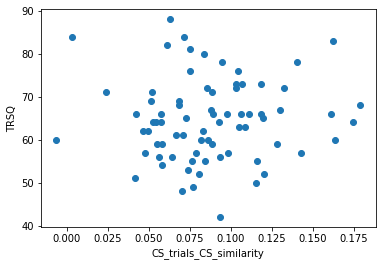

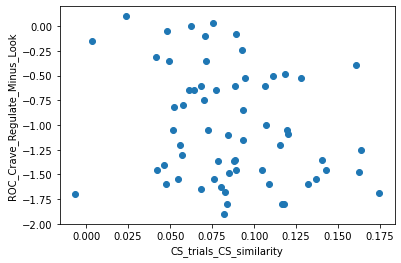

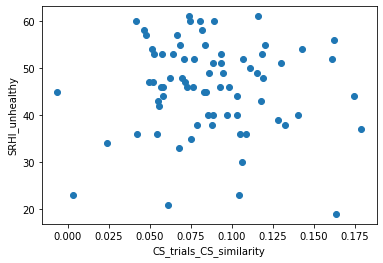

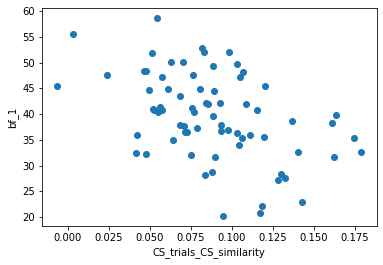

### CG_trials_CG_similarity

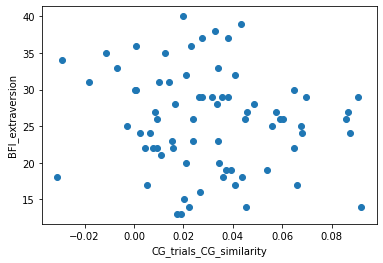

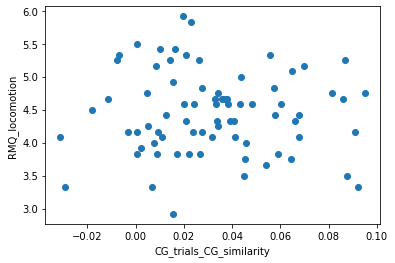

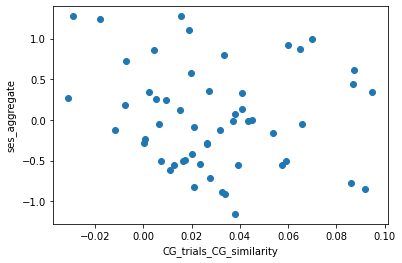

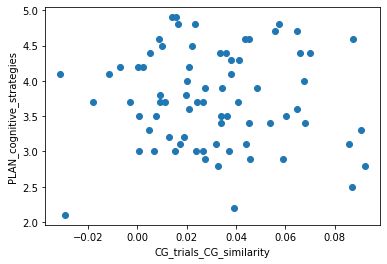

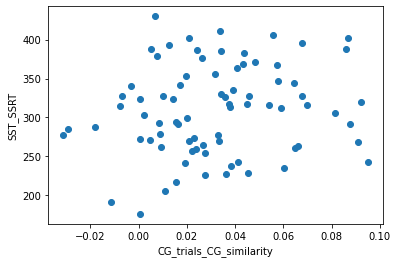

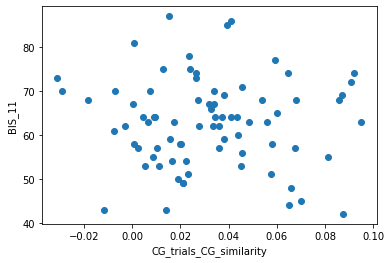

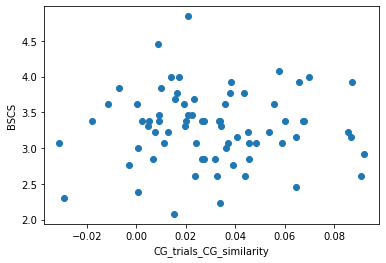

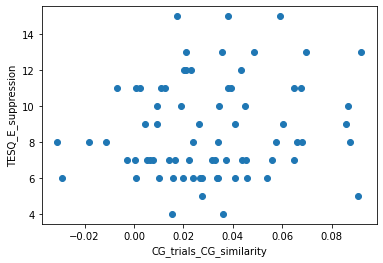

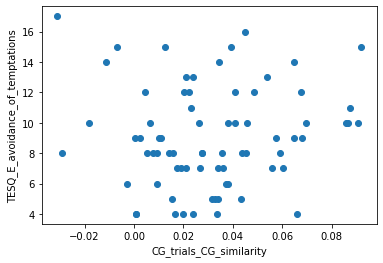

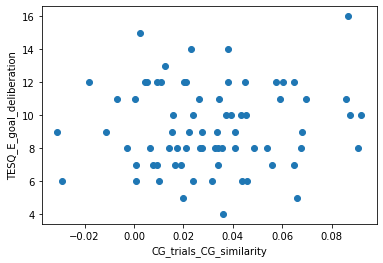

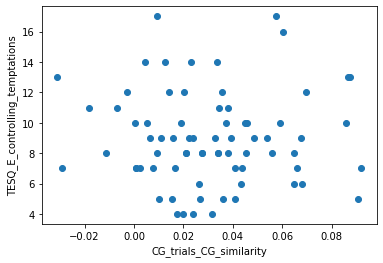

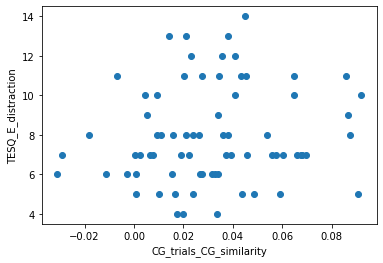

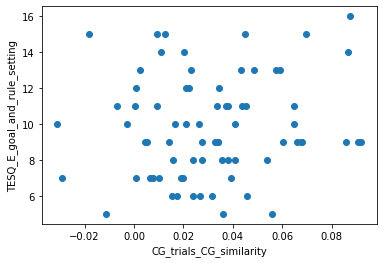

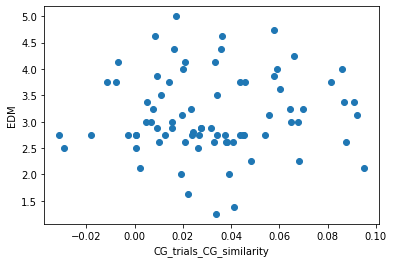

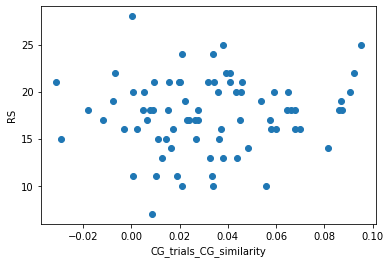

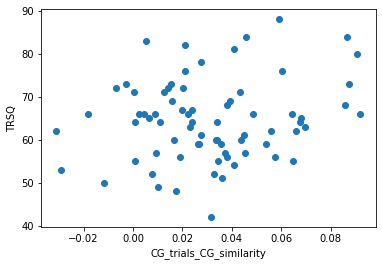

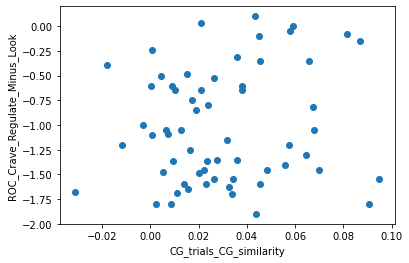

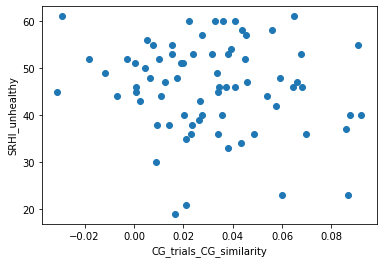

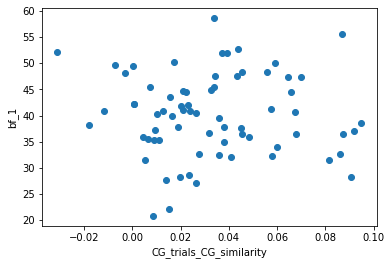

In [57]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func,
        mask=relevant_mask,
        clean=False,
        decoder_standardize=False
        
    )
    
    

print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

results[3]

correct_stop_ns=results[3]['CorrectStop']
display(Markdown("### correct_stop_ns"))
plotting.plot_img(correct_stop_ns,threshold='auto',bg_img=background_img)

correct_go_ns=results[3]['CorrectGo']
display(Markdown("### correct_go_ns"))
plotting.plot_img(correct_go_ns,threshold='auto',bg_img=background_img)

print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(correct_stop_ns,correct_go_ns)

print("loading data")

bd=get_bd(brain_data_filepath,correct_stop_ns,correct_go_ns,relevant_mask,'CG_similarity','CS_similarity')

create_histogram(bd,similarity1 = 'CG_similarity',similarity2 = 'CS_similarity',condition1 = 'CorrectStop',condition2='CorrectGo')

ind_div_combined = get_ind_div_for_sst(bd,ml_data_folderpath)

ind_div_combined_3sd = remove_selected_outliers_tesq_study(ind_div_combined,show_plot=True)
#PFC
for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy','bf_1']:
        visualize_corr(neural_var,correlate,ind_div_combined_3sd)
        

### whole brain

In [58]:

dataset_name = 'conditions'


In [59]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
results_filepath=ml_data_folderpath + "/SST/train_test_res_nozscore_" + dataset_name + "_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None

In [60]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func,
        clean=False,
        decoder_standardize=False
    )

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_wholebrain.pkl
0.845679012345679


### correct_stop_ns

### correct_go_ns

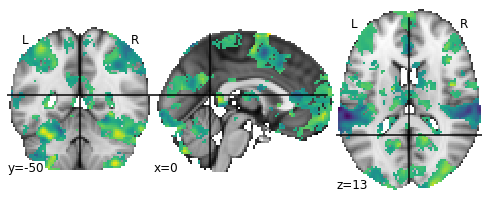

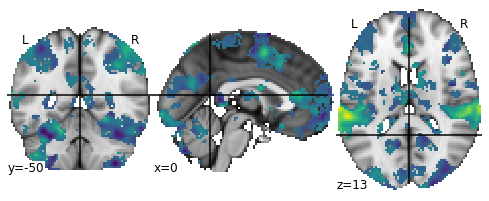

In [61]:

print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

results[3]

correct_stop_ns=results[3]['CorrectStop']
display(Markdown("### correct_stop_ns"))
plotting.plot_img(correct_stop_ns,threshold='auto',bg_img=background_img)

correct_go_ns=results[3]['CorrectGo']
display(Markdown("### correct_go_ns"))
plotting.plot_img(correct_go_ns,threshold='auto',bg_img=background_img)

In [62]:
from analyze_results import *

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


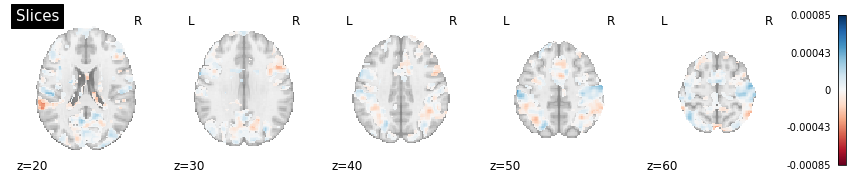

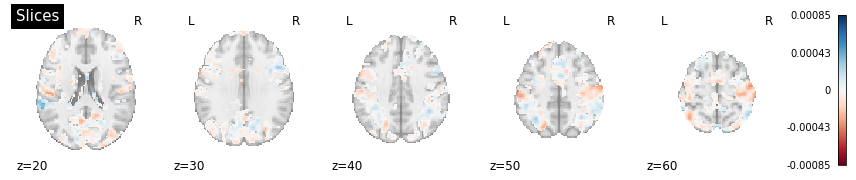

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


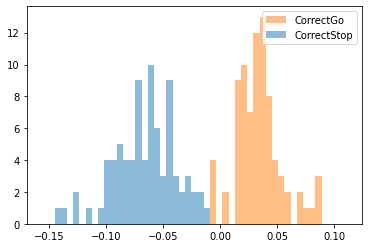

### CS_trials_CS_similarity

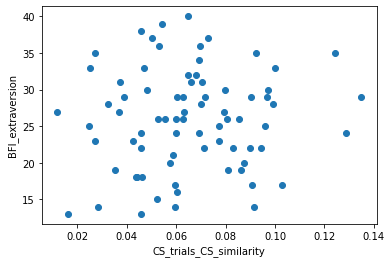

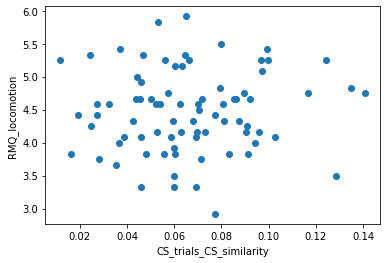

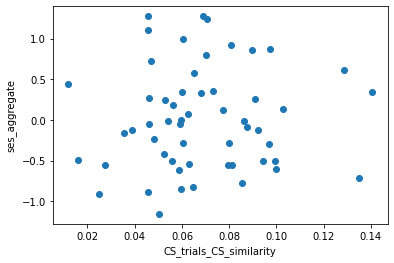

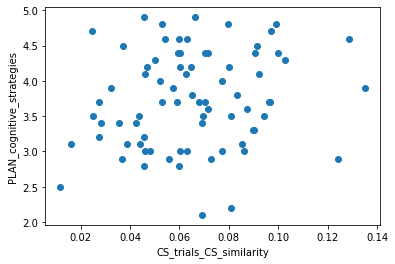

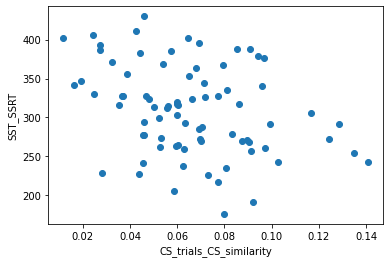

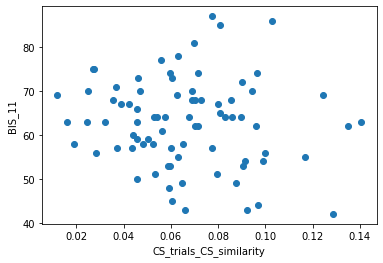

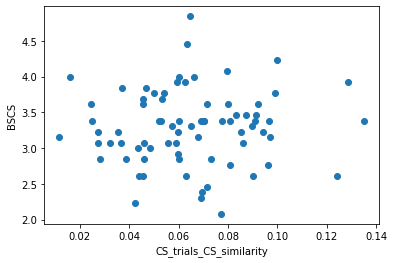

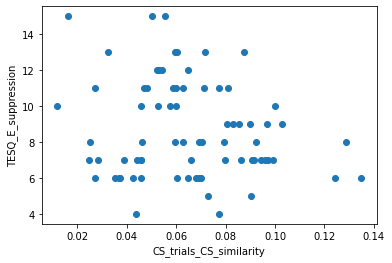

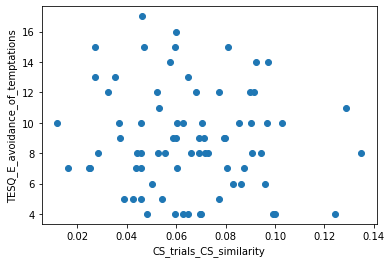

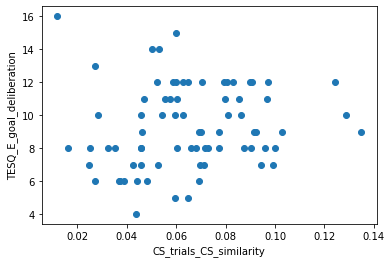

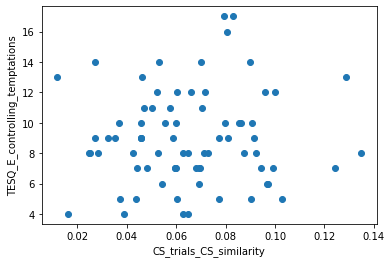

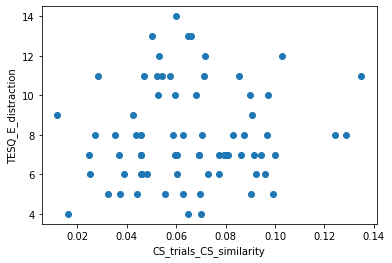

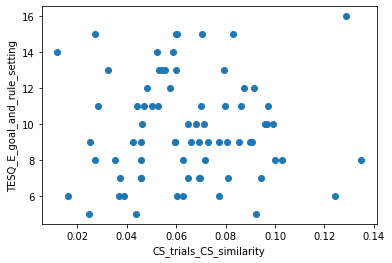

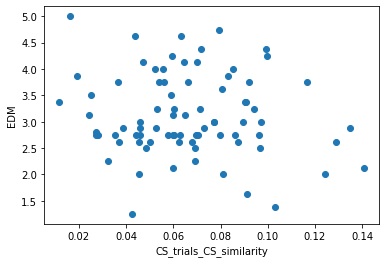

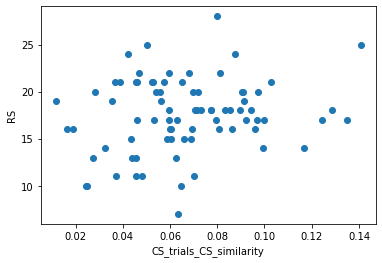

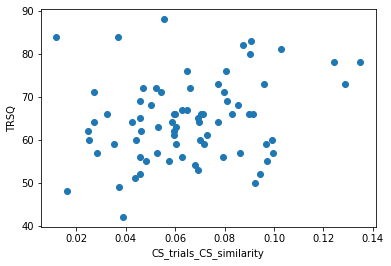

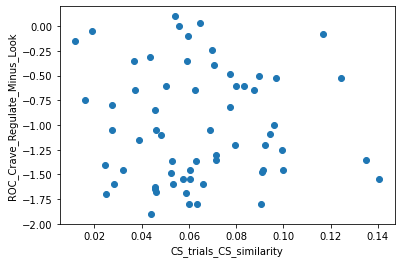

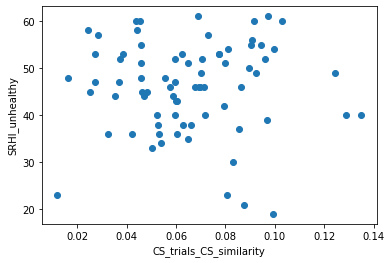

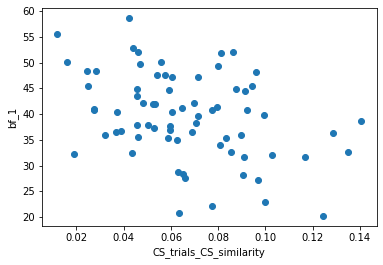

### CG_trials_CG_similarity

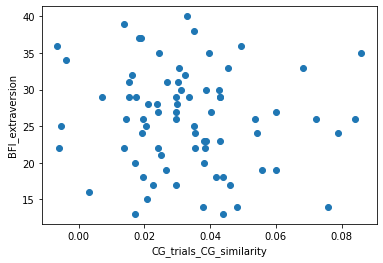

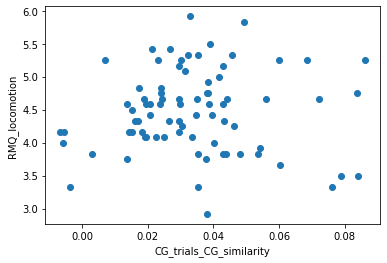

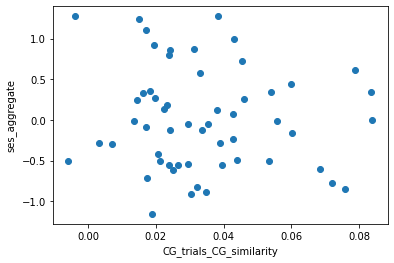

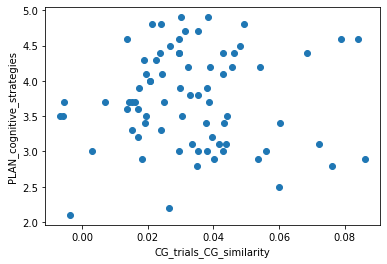

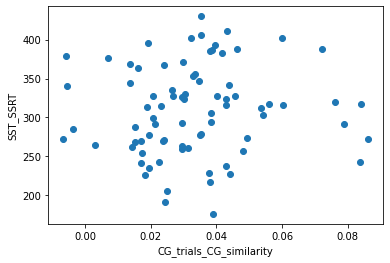

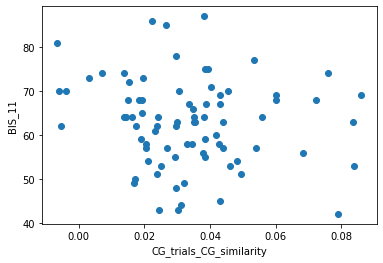

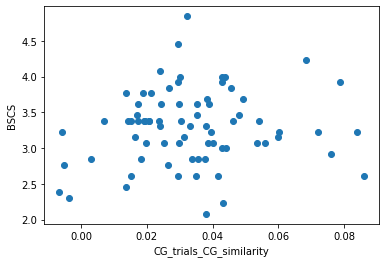

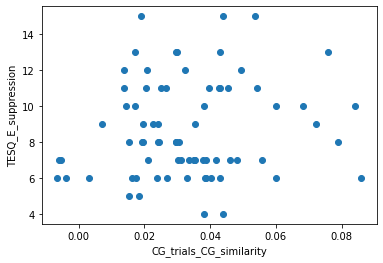

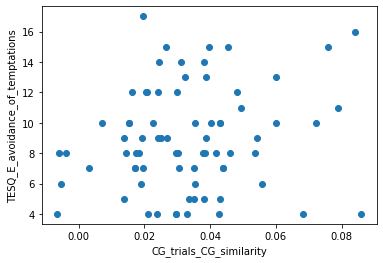

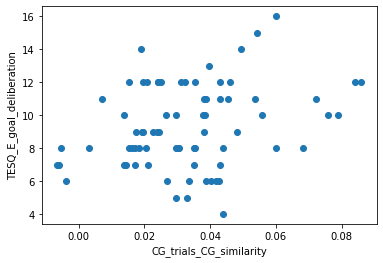

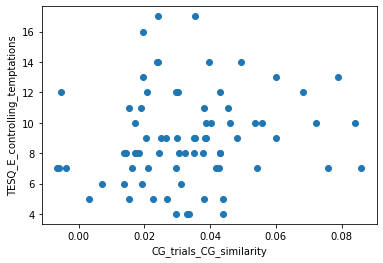

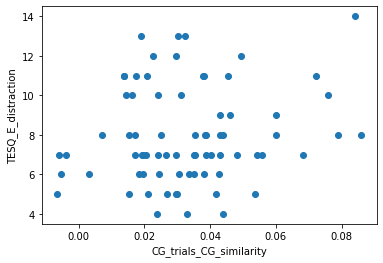

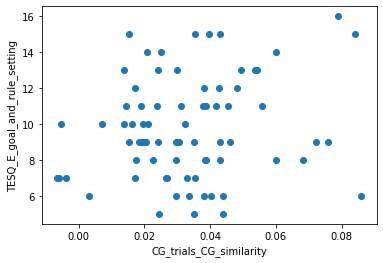

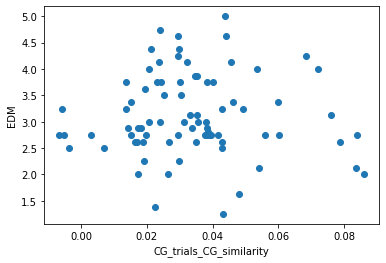

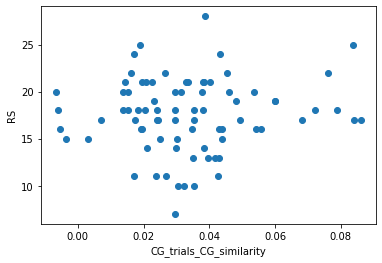

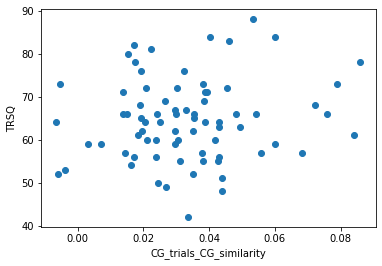

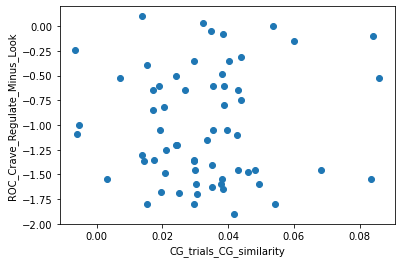

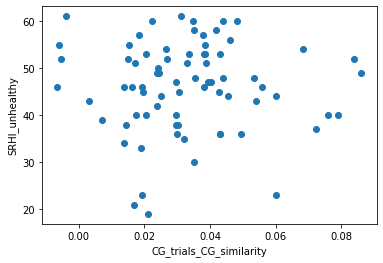

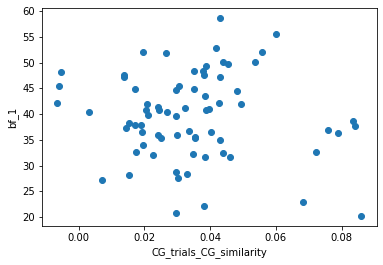

In [63]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(correct_stop_ns,correct_go_ns)

print("loading data")

bd=get_bd(brain_data_filepath,correct_stop_ns,correct_go_ns,relevant_mask,'CG_similarity','CS_similarity')

create_histogram(bd,similarity1 = 'CG_similarity',similarity2 = 'CS_similarity',condition1 = 'CorrectStop',condition2='CorrectGo')

ind_div_combined = get_ind_div_for_sst(bd,ml_data_folderpath)


ind_div_combined_3sd = remove_selected_outliers_tesq_study(ind_div_combined,show_plot=False)
#WHOLE-BRAIN
for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy','bf_1']:
        visualize_corr(neural_var,correlate,ind_div_combined_3sd)
        

In [49]:
#for neurosynth_mask_name in ['response inhibition','planning','inhibition','goal']:
    
def do_complete_analysis_for_mask(neurosynth_mask_name):
    display(Markdown("## " + neurosynth_mask_name))
    neurosynth_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/' + neurosynth_mask_name + '_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
    relevant_mask = neurosynth_mask
    
    dataset_name = 'conditions'


    brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
    #brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

    #set vars for the function
    results_filepath=ml_data_folderpath + "/SST/train_test_res_nozscore_" + dataset_name + "_84subs_twoclasses_" + neurosynth_mask_name + ".pkl"

    def decoderConstructor(*args, **kwargs):
        return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


    
    if path.exists(results_filepath) is False:
        apply_loocv_and_save(
            results_filepath = results_filepath,
            brain_data_filepath = brain_data_filepath,
            train_test_markers_filepath = train_test_markers_filepath,
    #        subjs_to_use = 60,
            decoderConstructor = decoderConstructor,
            response_transform_func=condition_resp_trans_func,
            mask=relevant_mask,
            clean=False,
            decoder_standardize=False
        )
    
    

    print(results_filepath)
    results=pickle.load(open(results_filepath,'rb'))

    print(np.mean(results[0]))

    results[3]

    correct_stop_ns=results[3]['CorrectStop']
    display(Markdown("### correct_stop_ns"))
    plotting.plot_img(correct_stop_ns,threshold='auto',bg_img=background_img)

    correct_go_ns=results[3]['CorrectGo']
    display(Markdown("### correct_go_ns"))
    plotting.plot_img(correct_go_ns,threshold='auto',bg_img=background_img)

    print(results_filepath,flush=True)

    print("plotting signatures")

    plot_stat_maps(correct_stop_ns,correct_go_ns)

    print("loading data")

    bd=get_bd(brain_data_filepath,correct_stop_ns,correct_go_ns,relevant_mask,'CG_similarity','CS_similarity')

    create_histogram(bd,similarity1 = 'CG_similarity',similarity2 = 'CS_similarity',condition1 = 'CorrectStop',condition2='CorrectGo')

    ind_div_combined = get_ind_div_for_sst(bd,ml_data_folderpath)
    
    neural_vars = ['CS_trials_CS_similarity','CG_trials_CG_similarity']
    correlates = ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                          'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                         'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy','bf_1']
    
    ind_div_combined_3sd = remove_selected_outliers_tesq_study(ind_div_combined,show_plot=True)

    
    for neural_var in neural_vars:
        display(Markdown("### " + neural_var))
        for correlate in correlates:
            visualize_corr(neural_var,correlate,ind_div_combined)





## response inhibition

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_response inhibition.pkl
0.6728395061728395


### correct_stop_ns

### correct_go_ns

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_response inhibition.pkl
plotting signatures


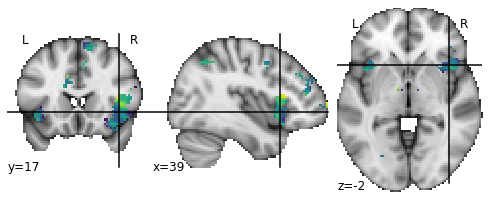

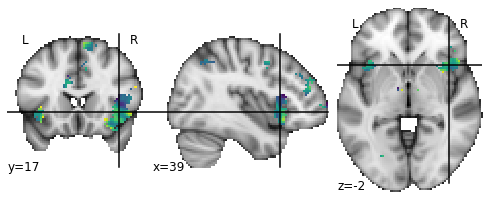

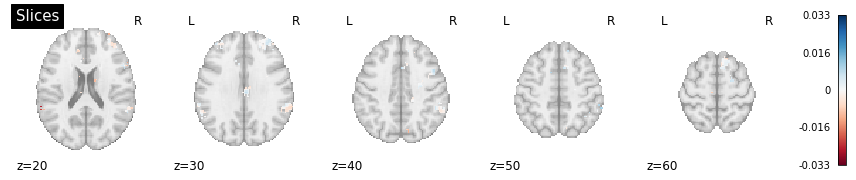

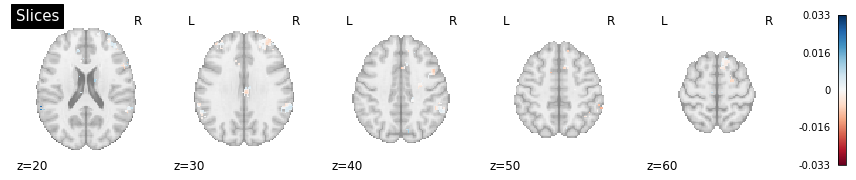

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


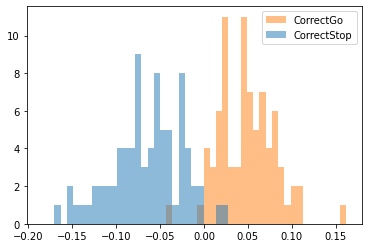

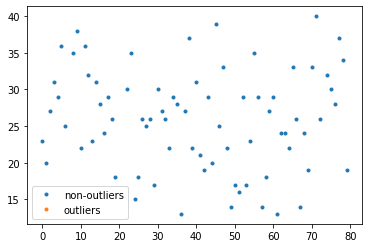

76 , 76


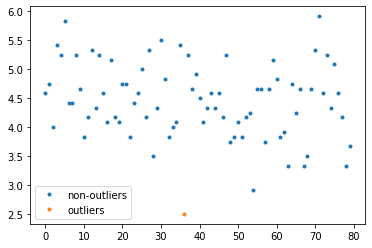

80 , 79


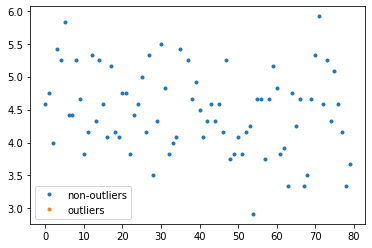

79 , 79


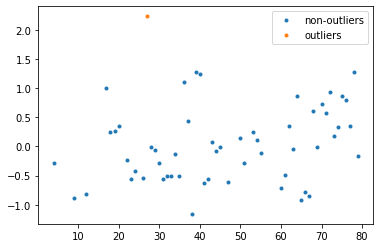

56 , 55


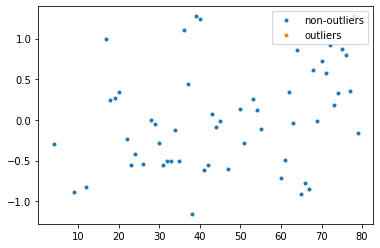

55 , 55


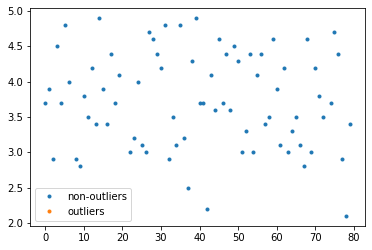

76 , 76


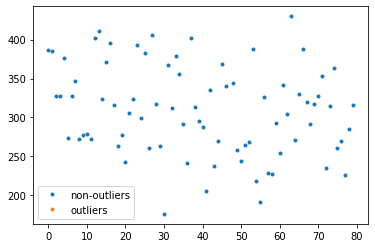

79 , 79


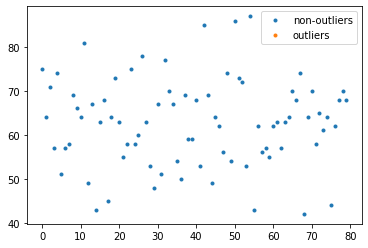

80 , 80


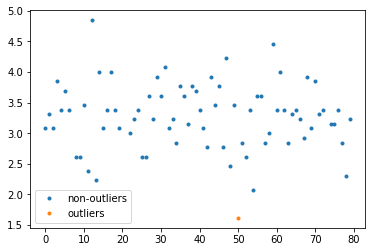

76 , 75


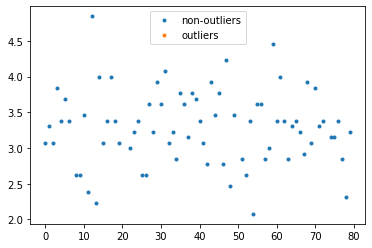

75 , 75


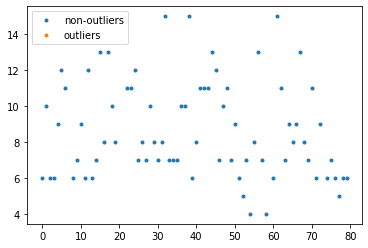

75 , 75


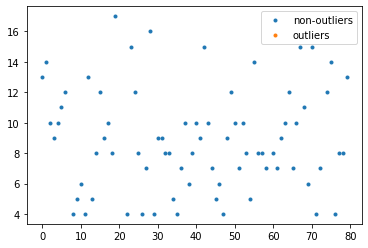

75 , 75


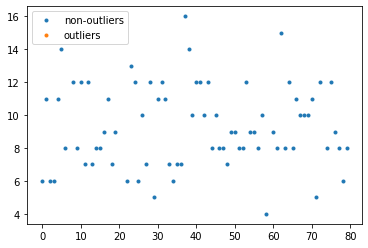

75 , 75


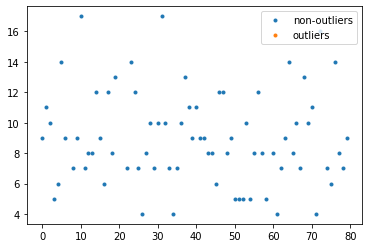

75 , 75


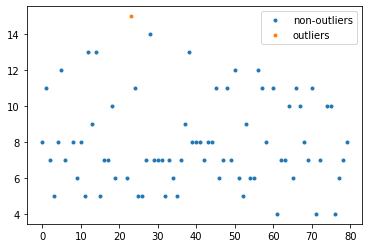

75 , 74


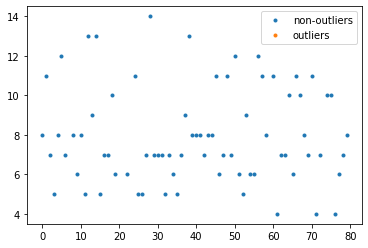

74 , 74


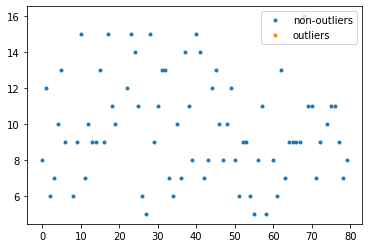

75 , 75


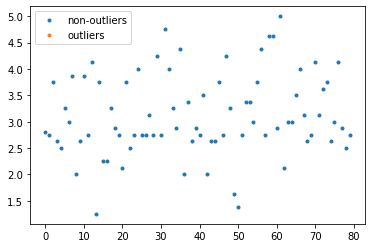

80 , 80


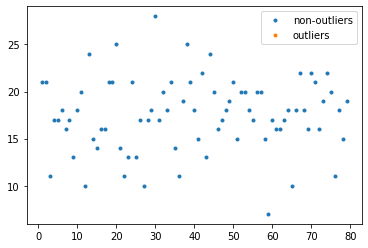

79 , 79


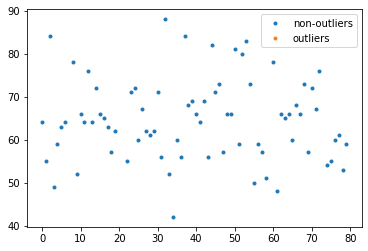

75 , 75


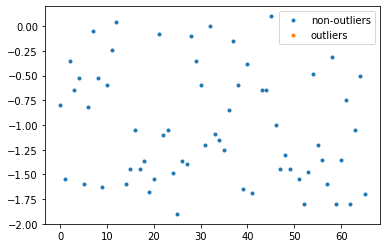

63 , 63


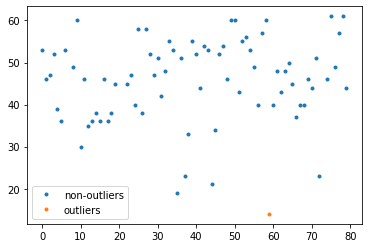

76 , 75


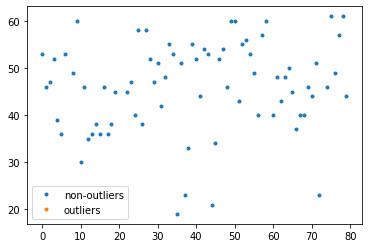

75 , 75


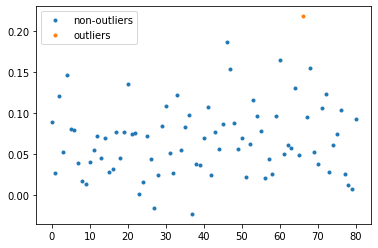

81 , 80


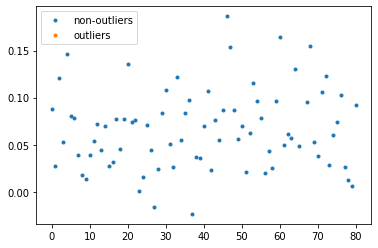

80 , 80


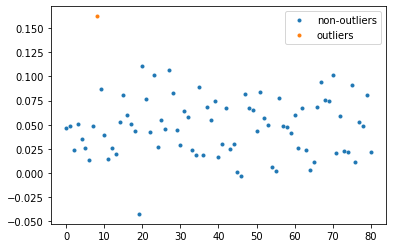

81 , 80


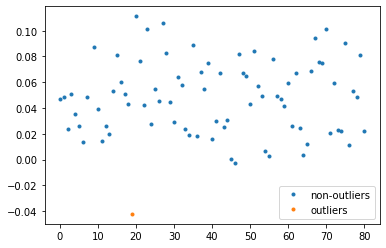

80 , 79


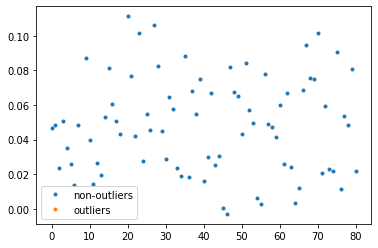

79 , 79


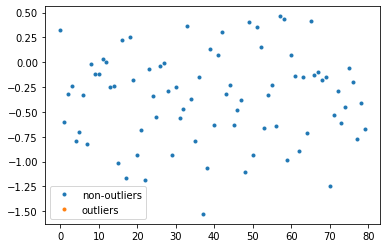

80 , 80


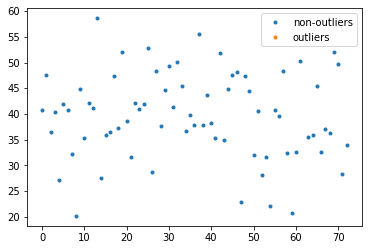

72 , 72


### CS_trials_CS_similarity

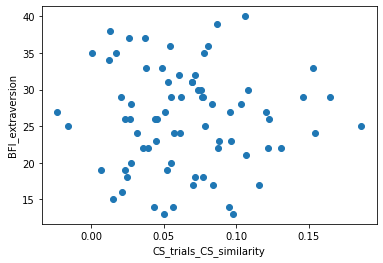

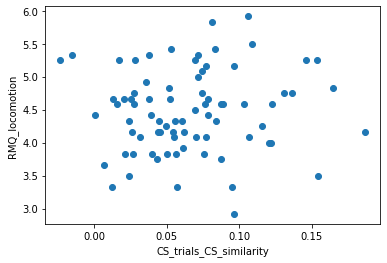

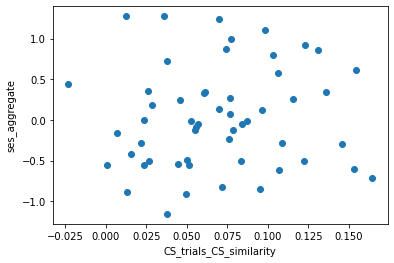

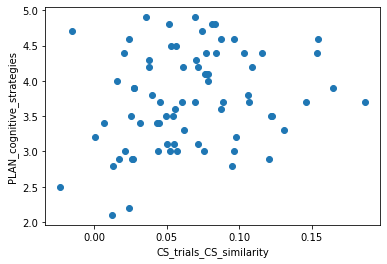

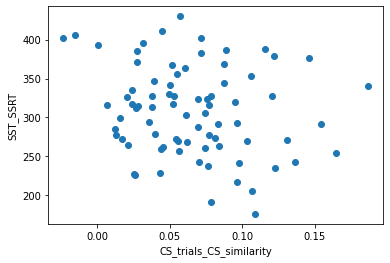

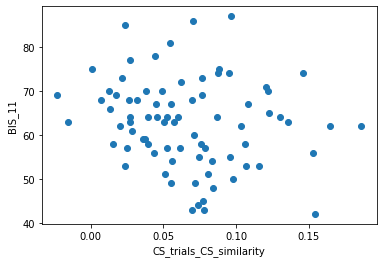

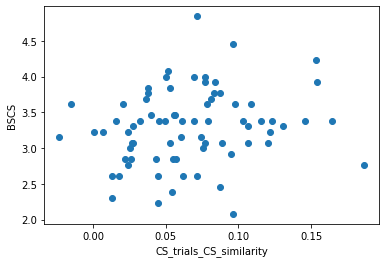

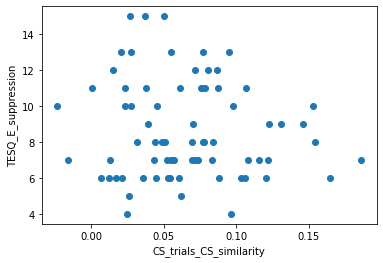

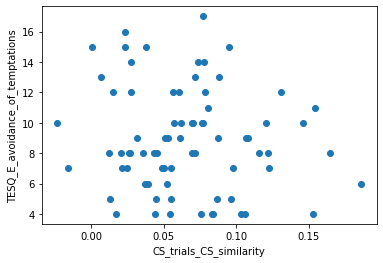

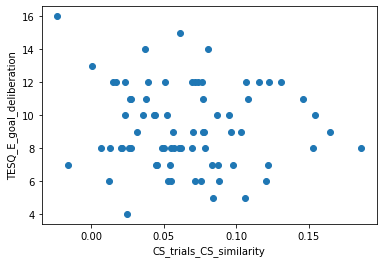

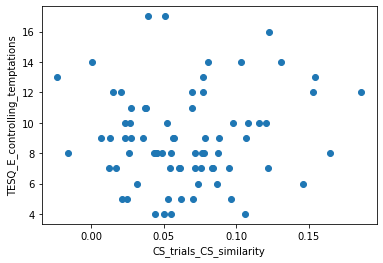

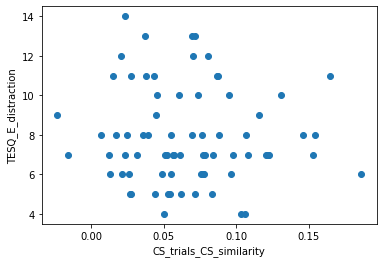

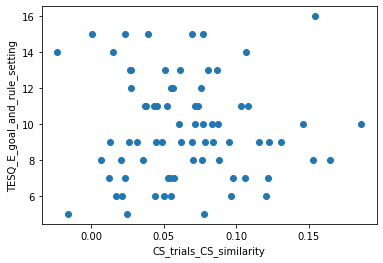

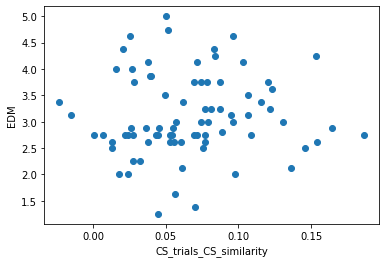

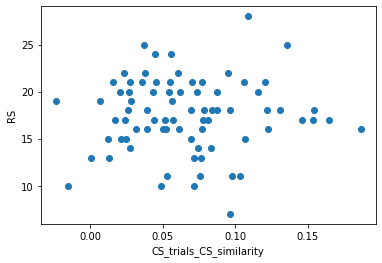

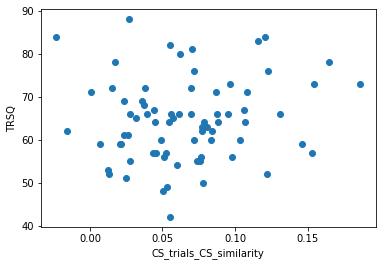

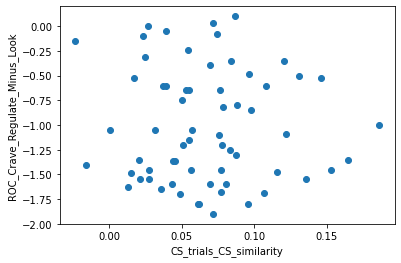

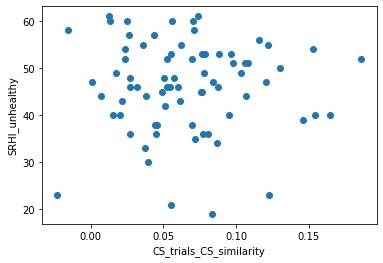

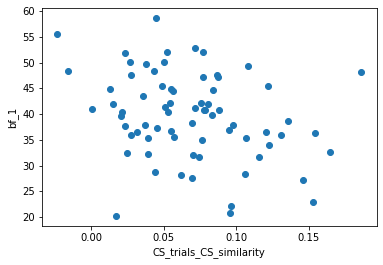

### CG_trials_CG_similarity

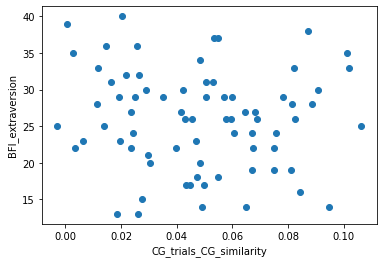

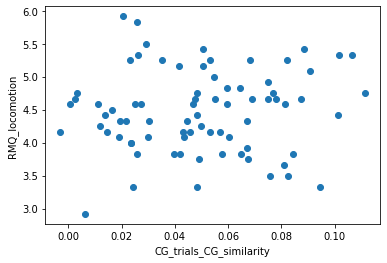

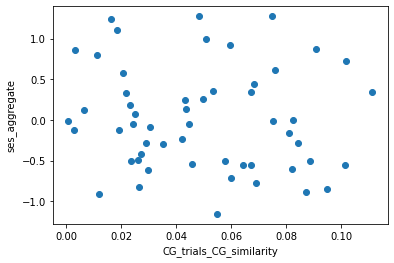

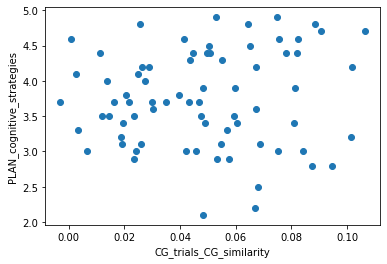

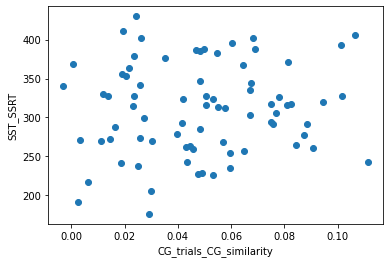

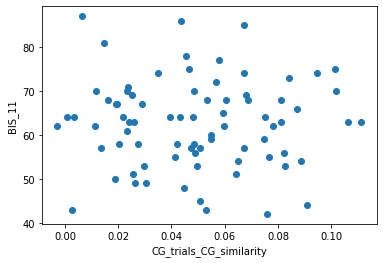

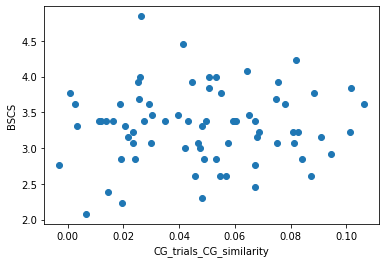

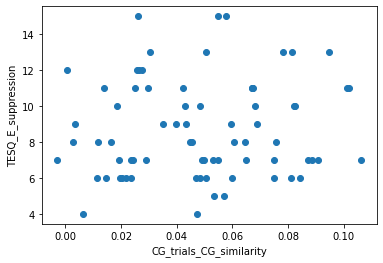

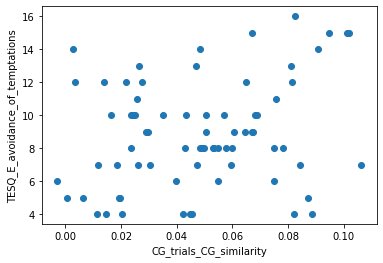

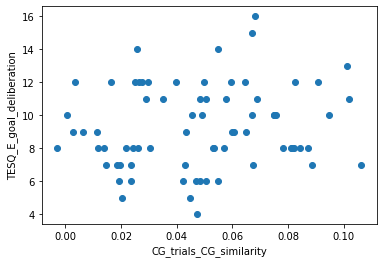

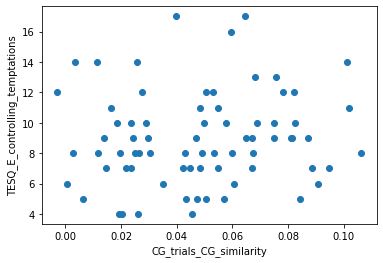

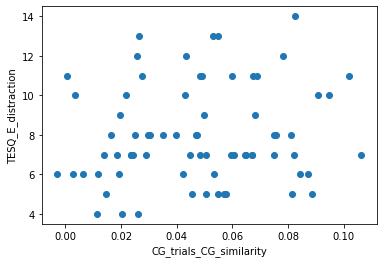

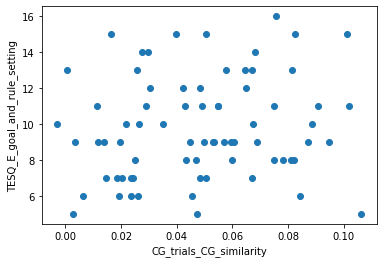

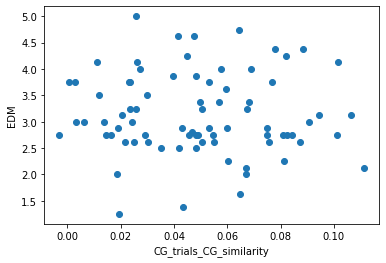

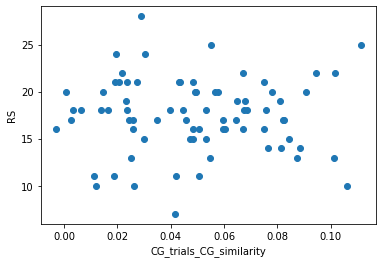

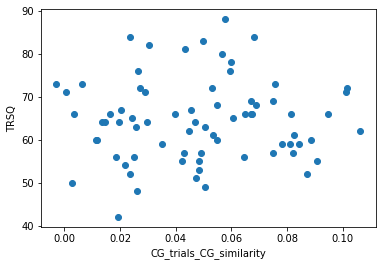

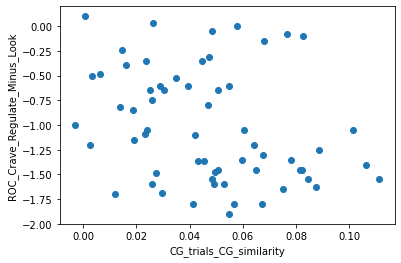

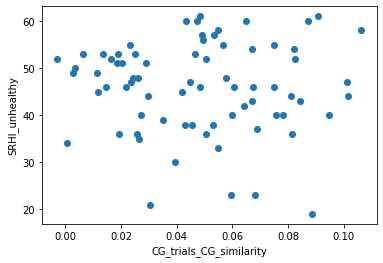

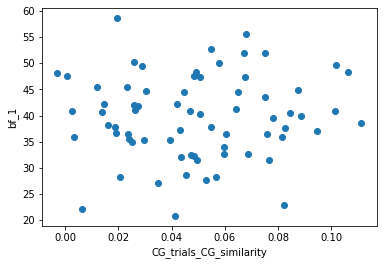

In [50]:
do_complete_analysis_for_mask('response inhibition')

## planning

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_planning.pkl
0.7407407407407407


### correct_stop_ns

### correct_go_ns

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_planning.pkl
plotting signatures


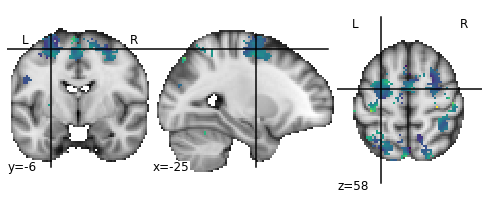

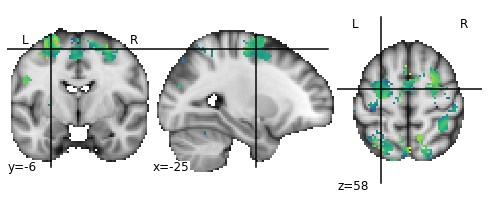

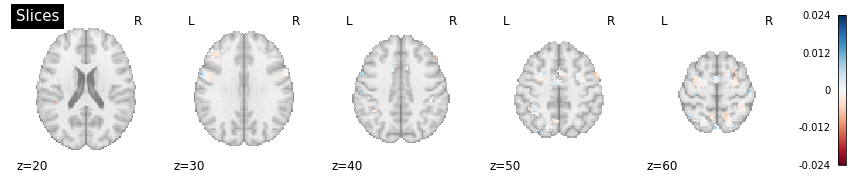

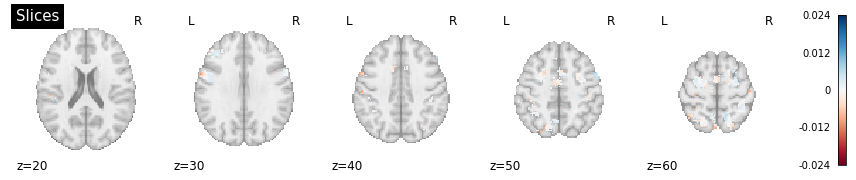

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


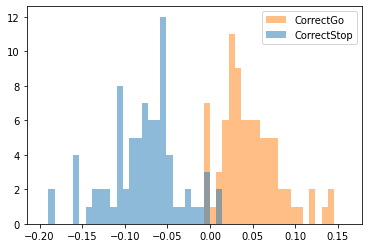

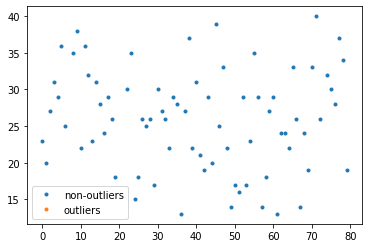

76 , 76


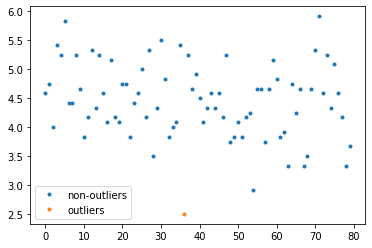

80 , 79


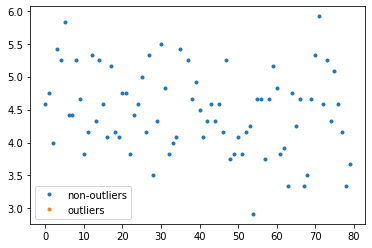

79 , 79


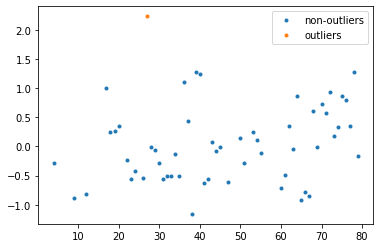

56 , 55


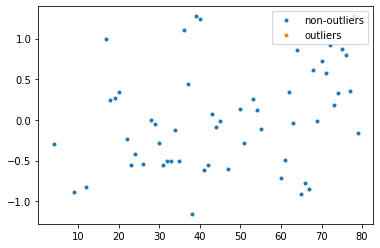

55 , 55


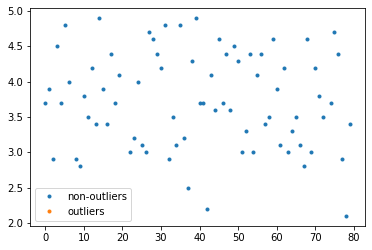

76 , 76


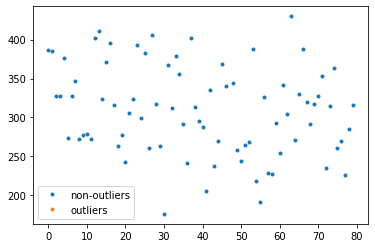

79 , 79


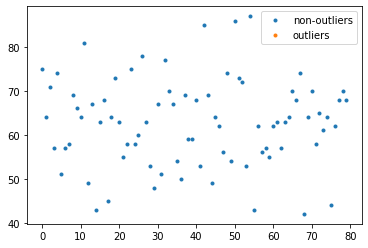

80 , 80


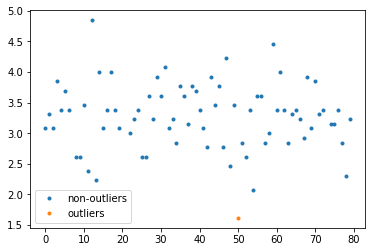

76 , 75


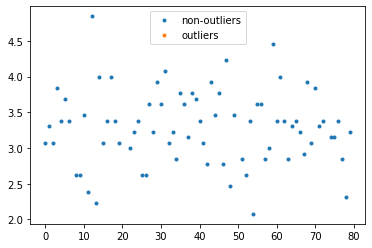

75 , 75


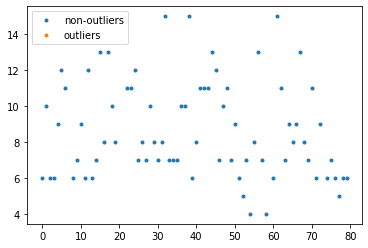

75 , 75


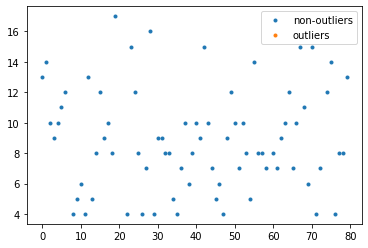

75 , 75


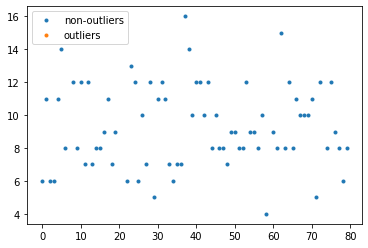

75 , 75


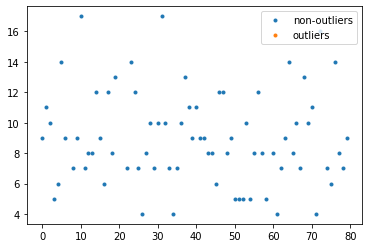

75 , 75


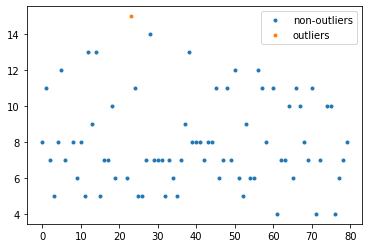

75 , 74


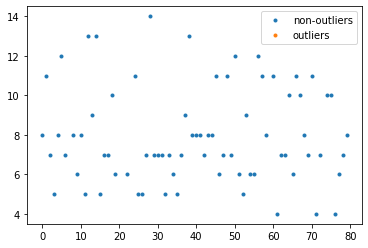

74 , 74


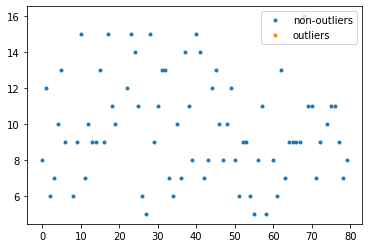

75 , 75


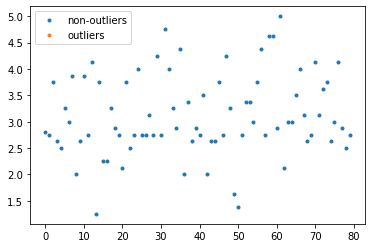

80 , 80


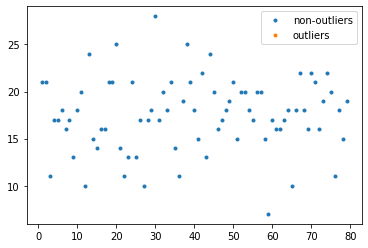

79 , 79


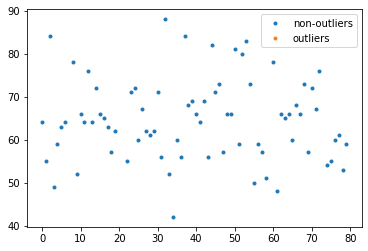

75 , 75


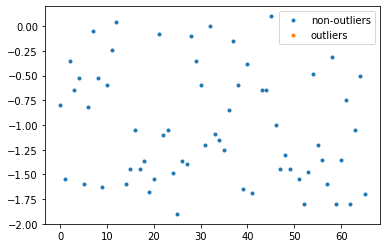

63 , 63


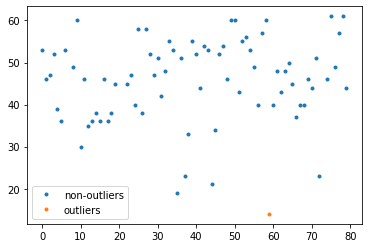

76 , 75


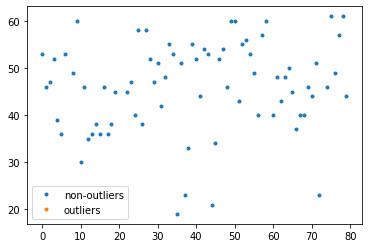

75 , 75


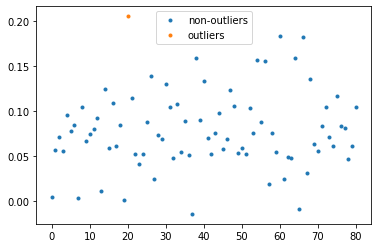

81 , 80


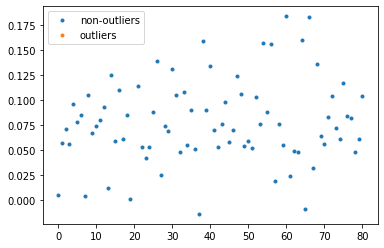

80 , 80


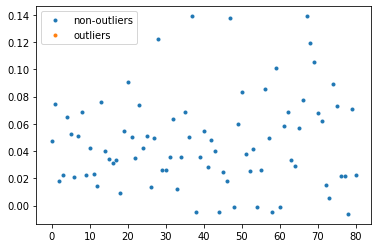

81 , 81


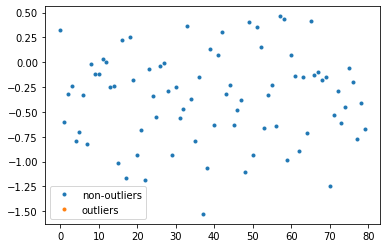

80 , 80


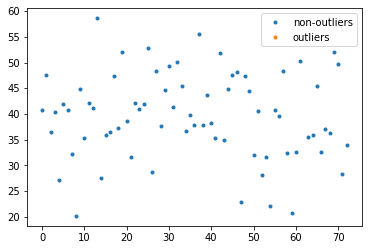

72 , 72


### CS_trials_CS_similarity

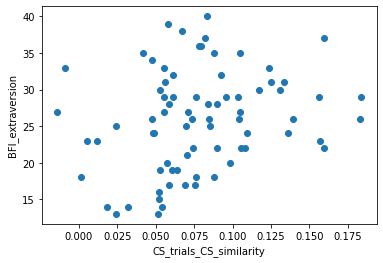

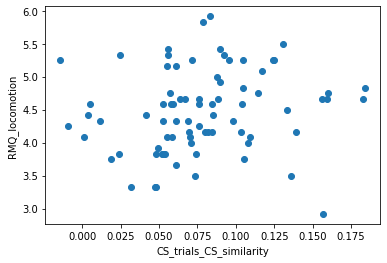

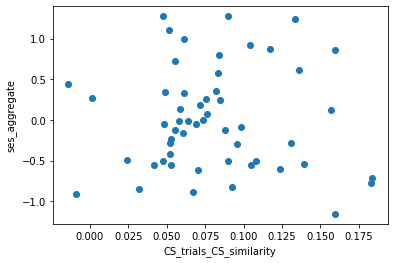

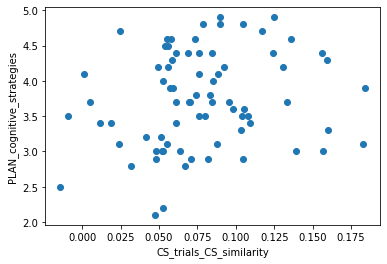

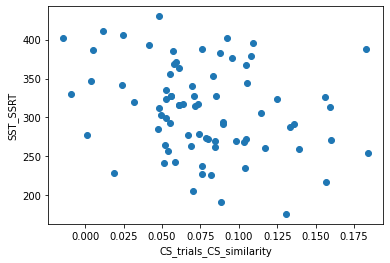

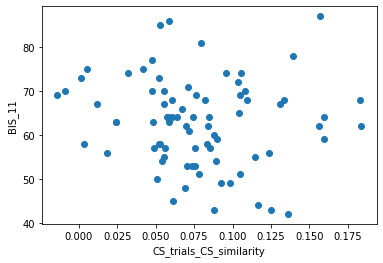

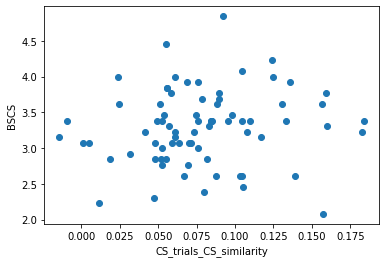

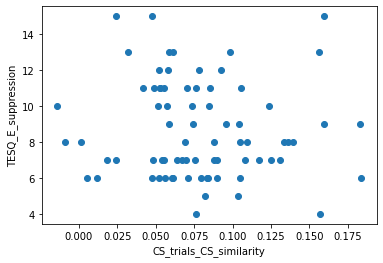

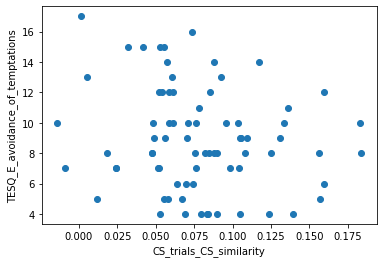

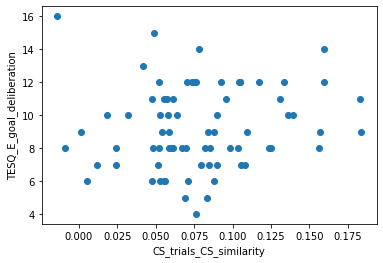

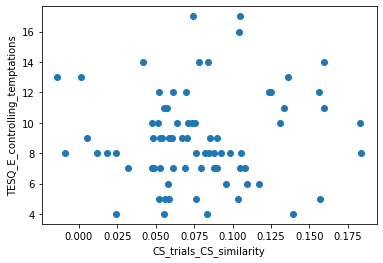

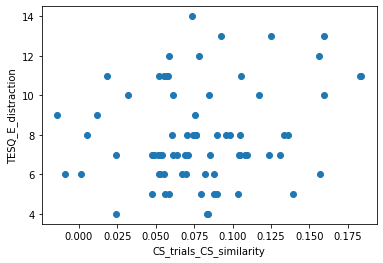

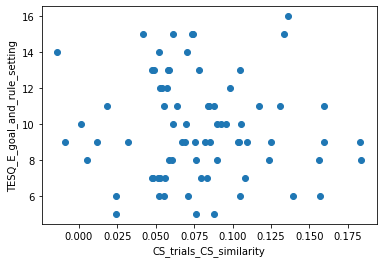

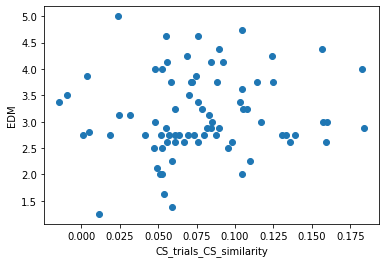

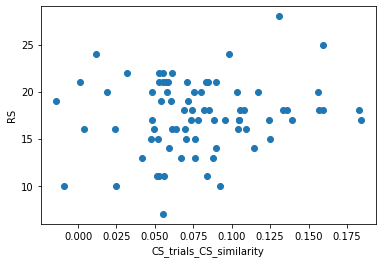

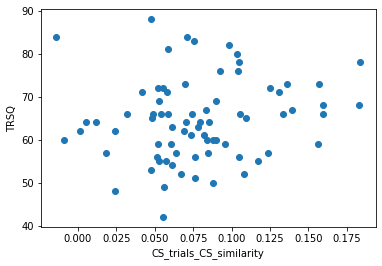

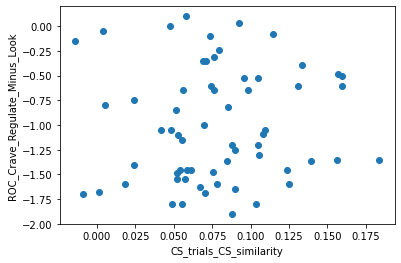

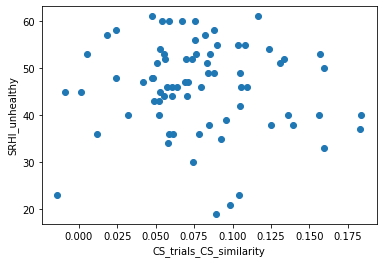

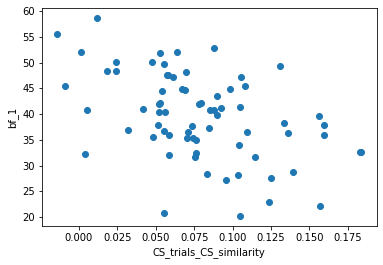

### CG_trials_CG_similarity

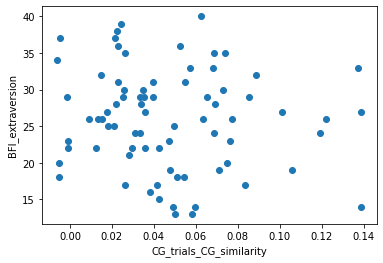

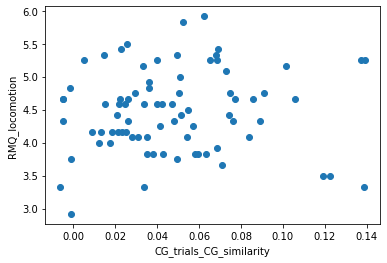

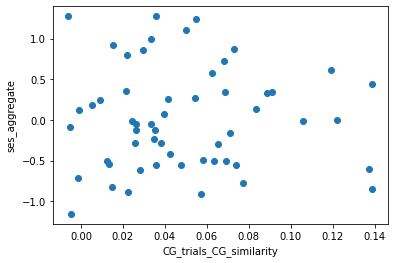

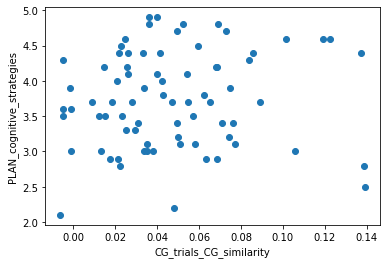

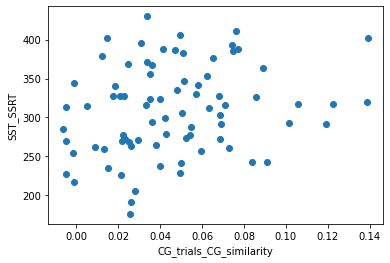

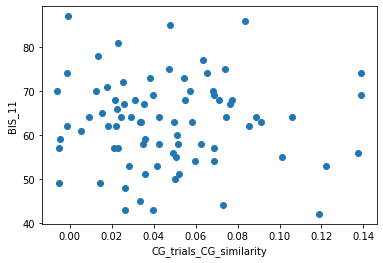

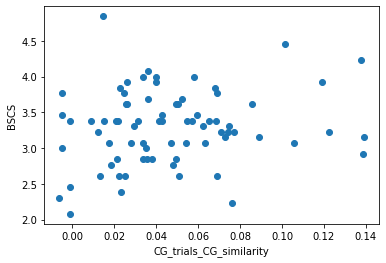

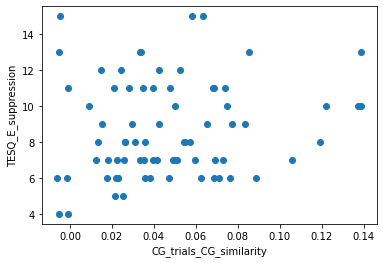

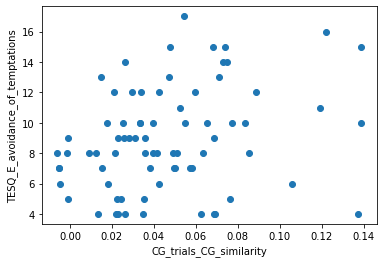

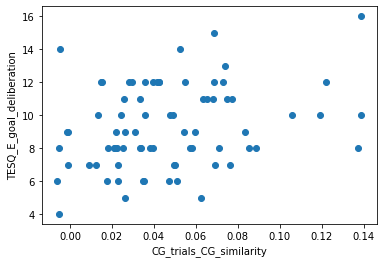

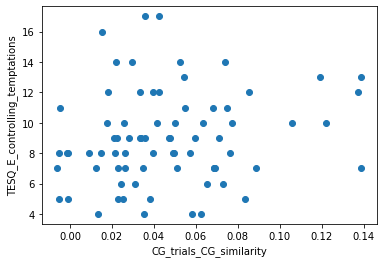

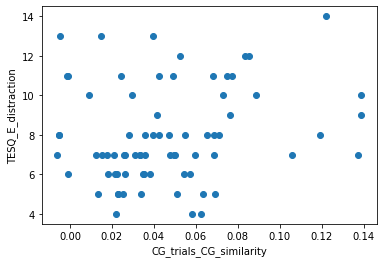

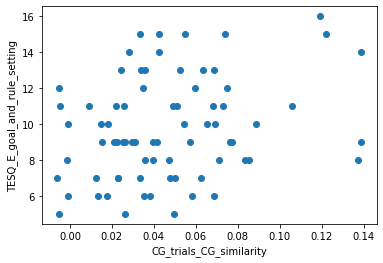

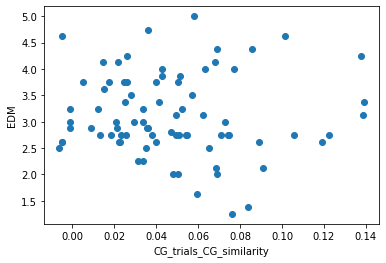

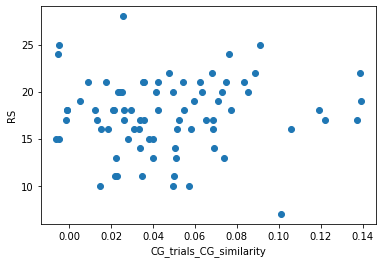

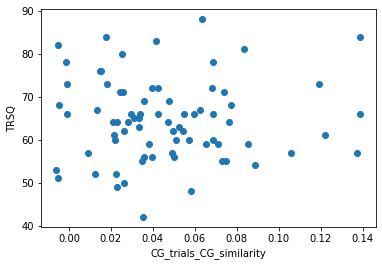

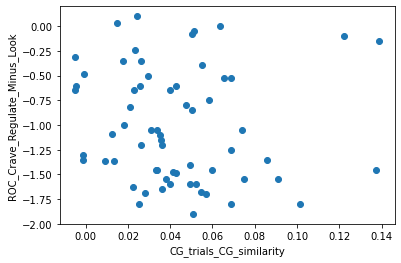

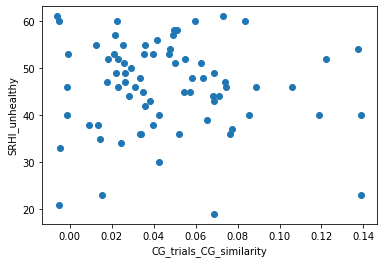

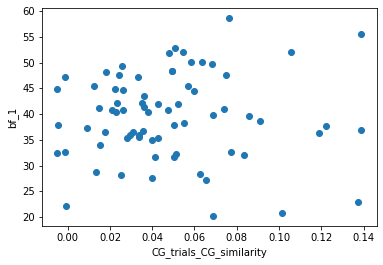

In [51]:
do_complete_analysis_for_mask('planning')

## inhibition

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_inhibition.pkl
0.6604938271604939


### correct_stop_ns

### correct_go_ns

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_inhibition.pkl
plotting signatures


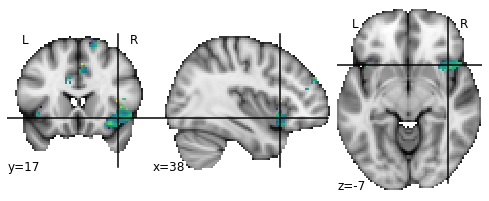

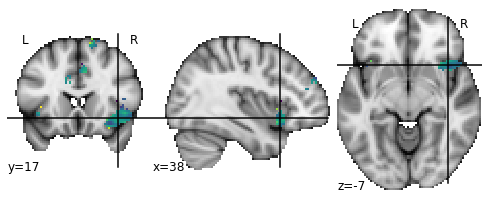

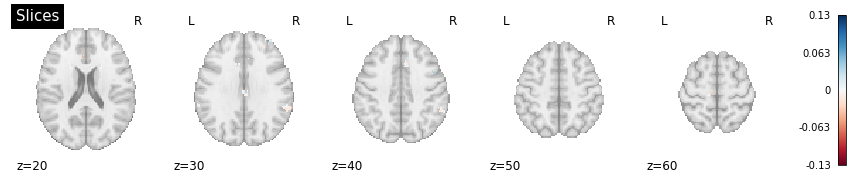

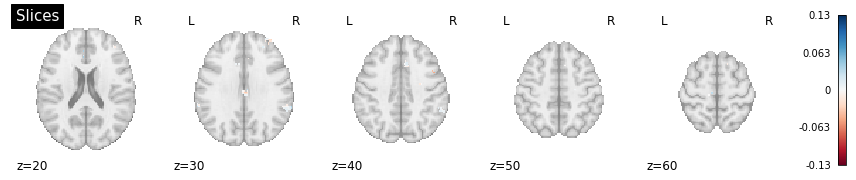

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


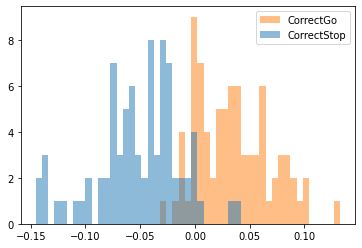

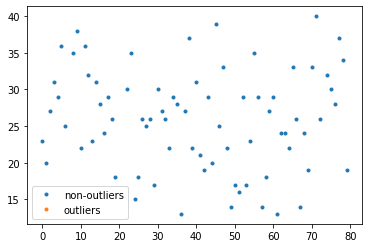

76 , 76


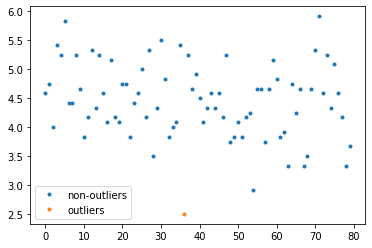

80 , 79


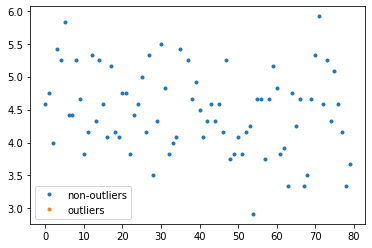

79 , 79


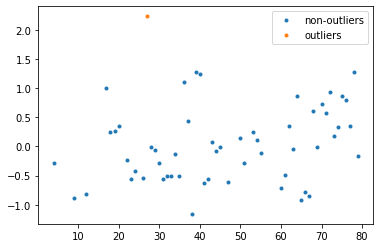

56 , 55


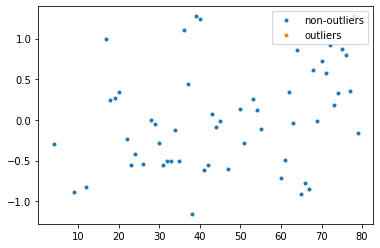

55 , 55


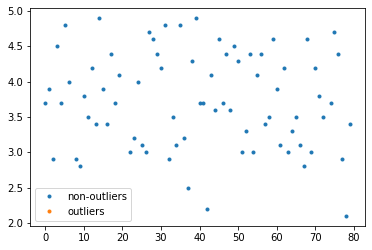

76 , 76


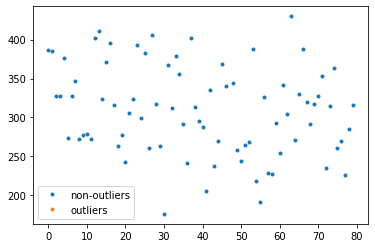

79 , 79


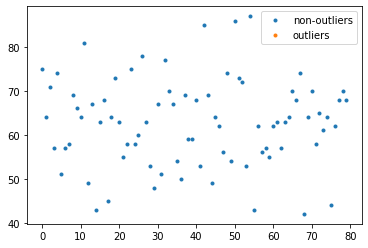

80 , 80


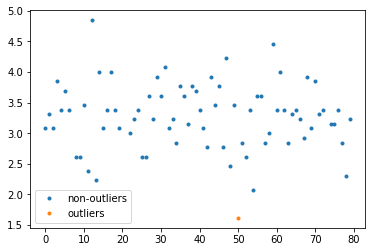

76 , 75


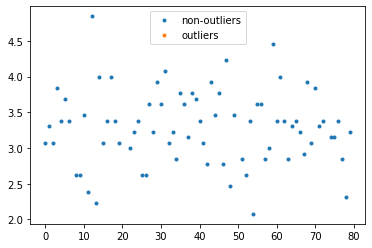

75 , 75


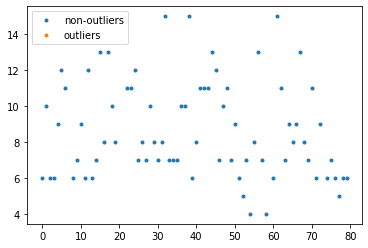

75 , 75


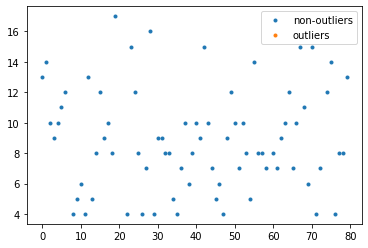

75 , 75


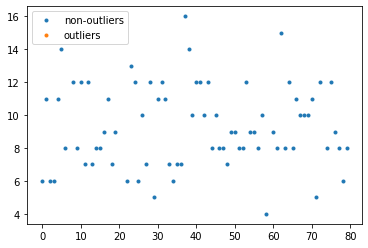

75 , 75


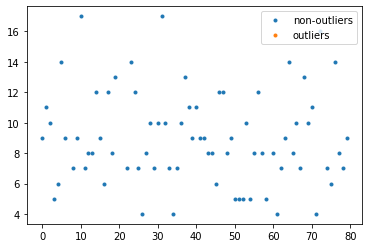

75 , 75


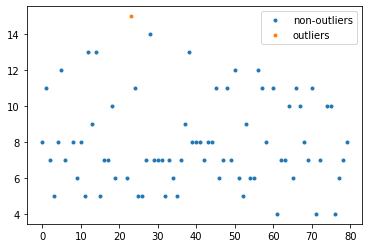

75 , 74


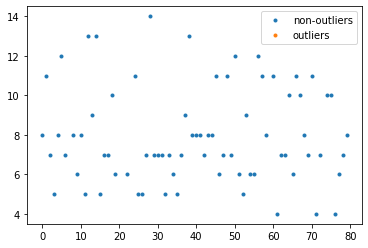

74 , 74


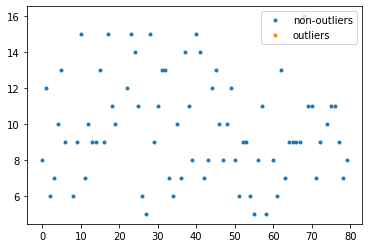

75 , 75


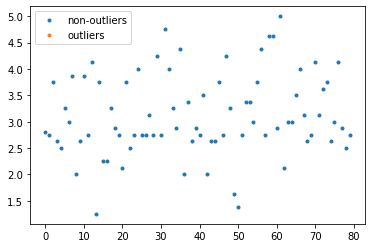

80 , 80


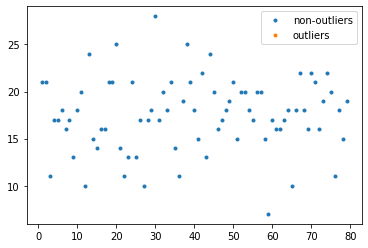

79 , 79


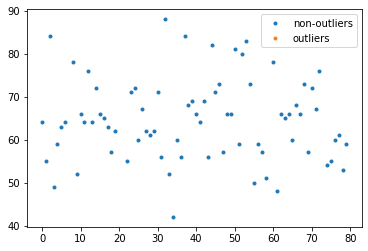

75 , 75


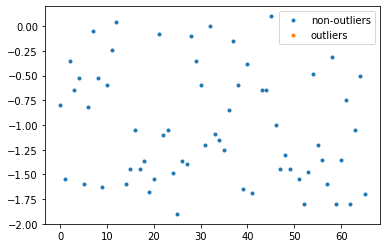

63 , 63


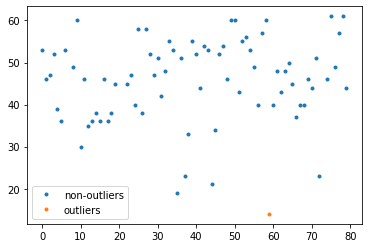

76 , 75


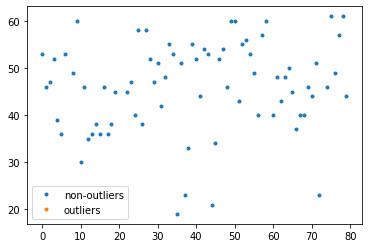

75 , 75


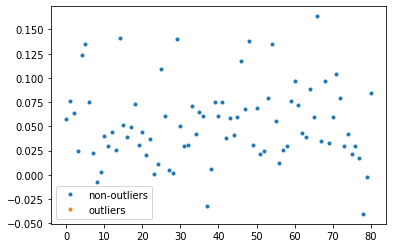

81 , 81


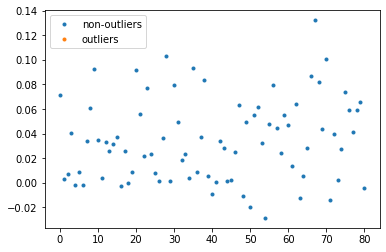

81 , 81


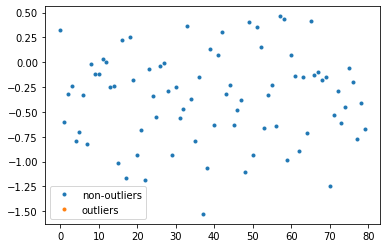

80 , 80


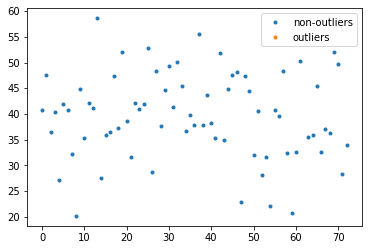

72 , 72


### CS_trials_CS_similarity

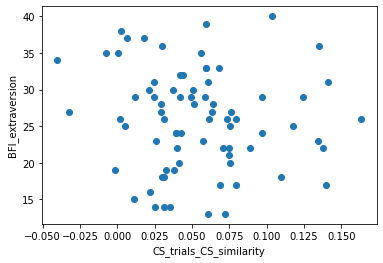

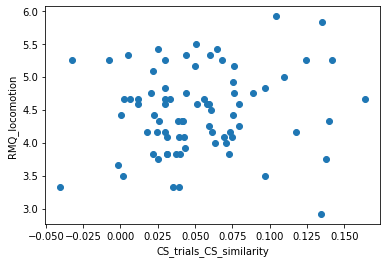

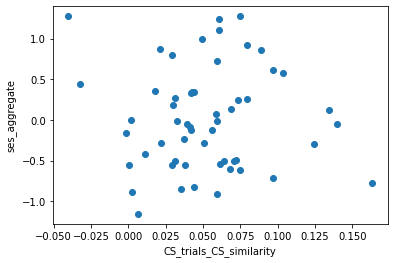

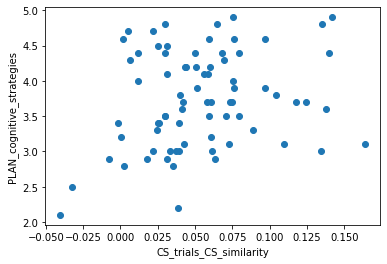

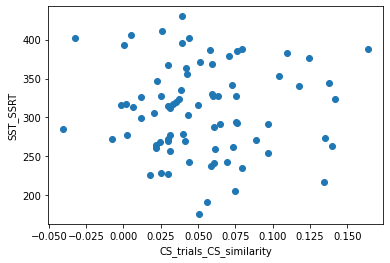

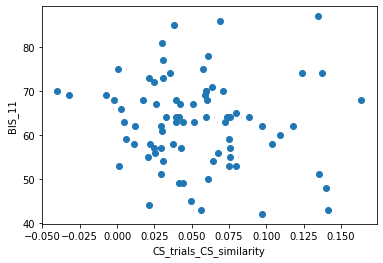

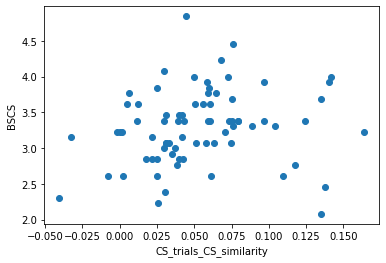

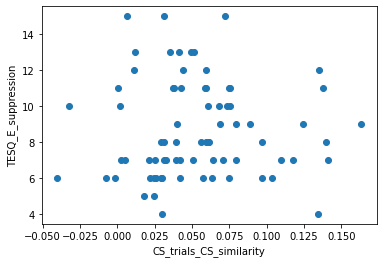

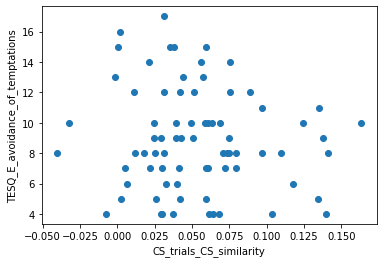

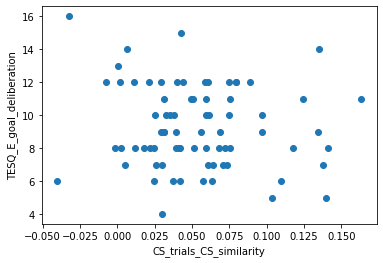

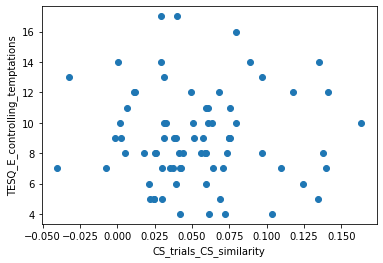

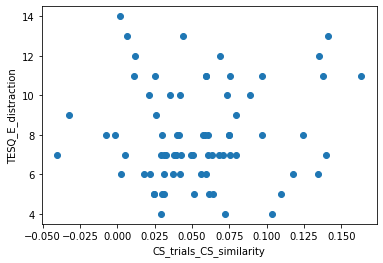

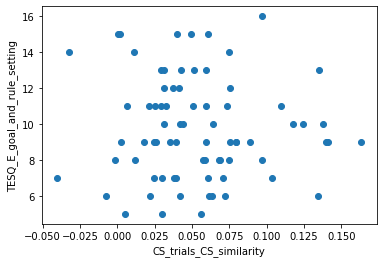

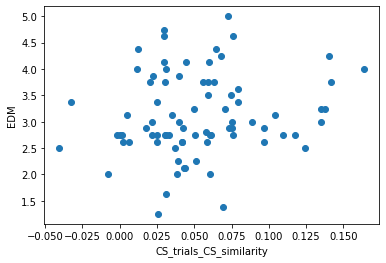

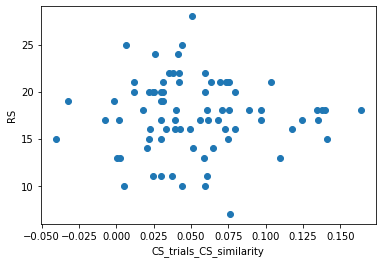

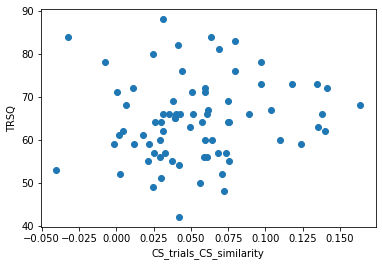

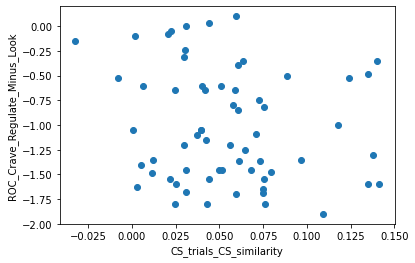

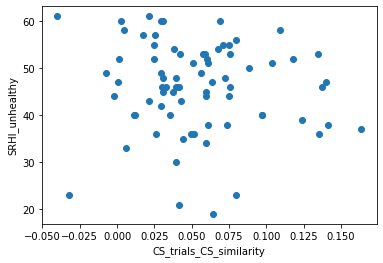

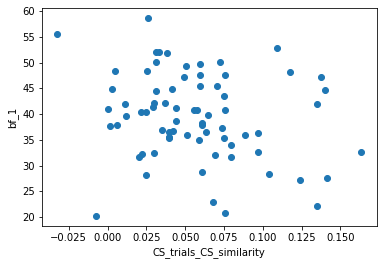

### CG_trials_CG_similarity

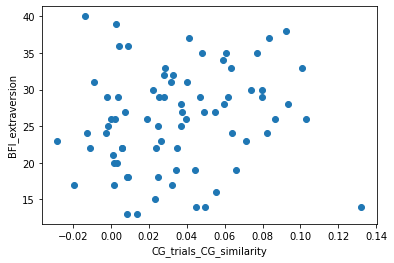

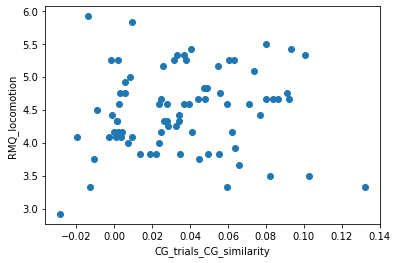

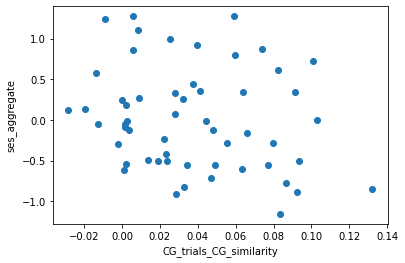

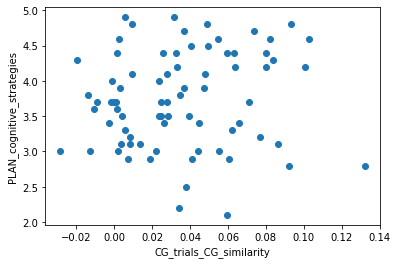

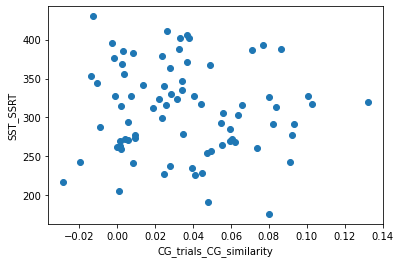

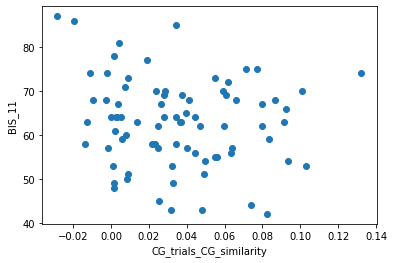

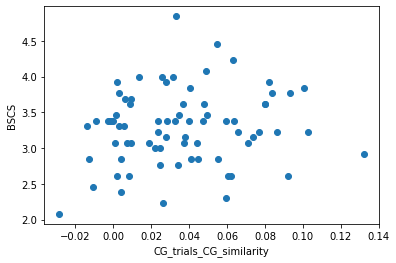

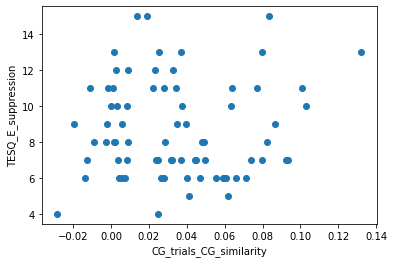

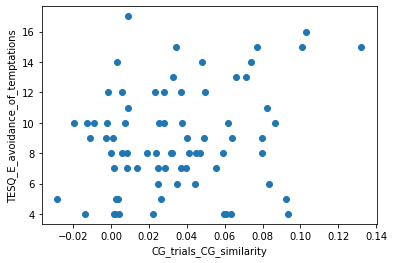

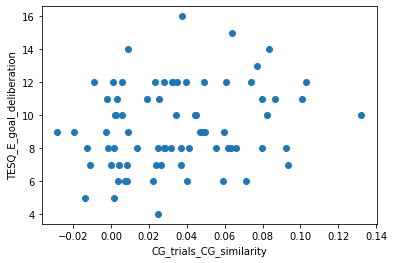

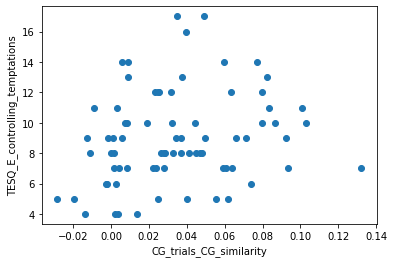

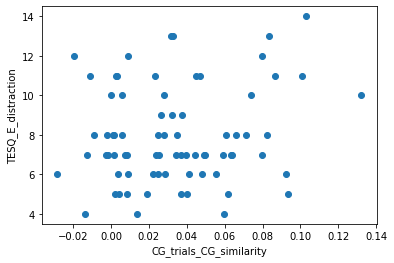

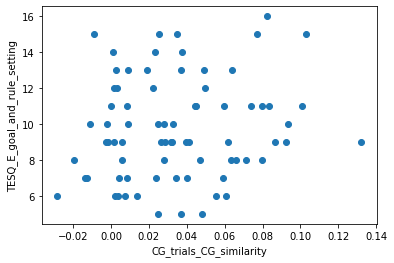

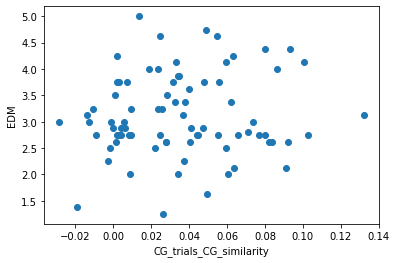

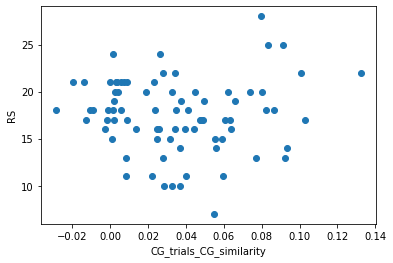

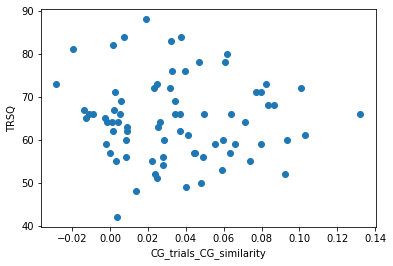

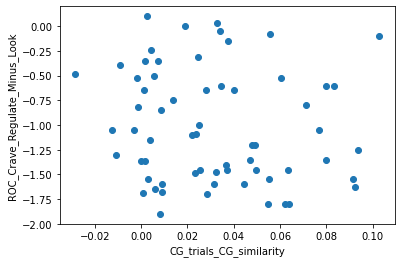

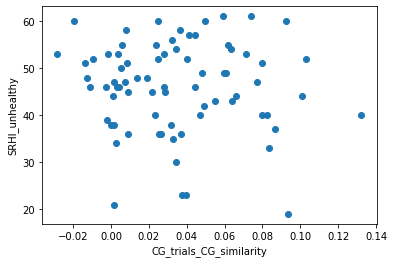

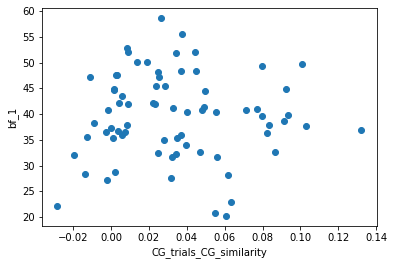

In [52]:
do_complete_analysis_for_mask('inhibition')

## goal

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_goal.pkl
0.6728395061728395


### correct_stop_ns

### correct_go_ns

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_conditions_84subs_twoclasses_goal.pkl
plotting signatures


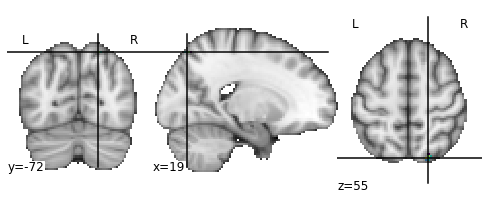

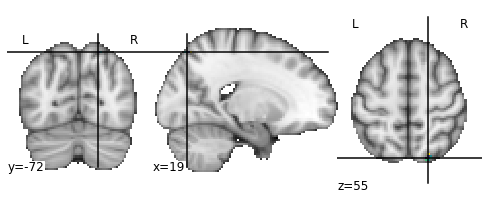

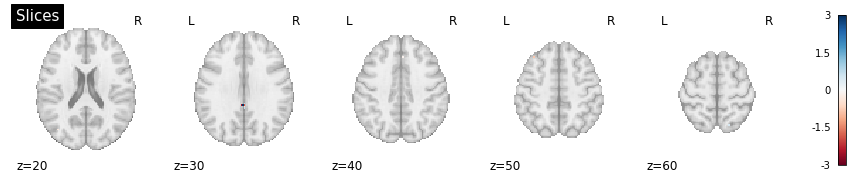

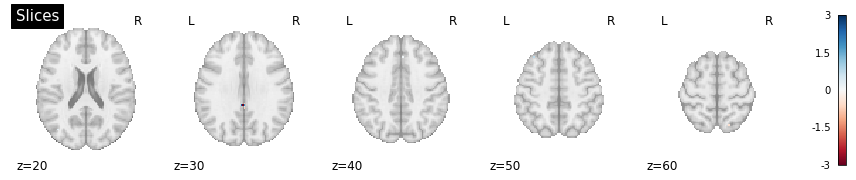

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


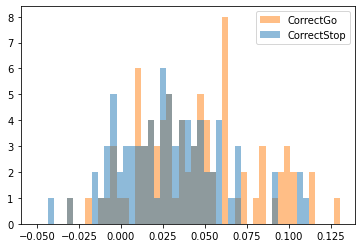

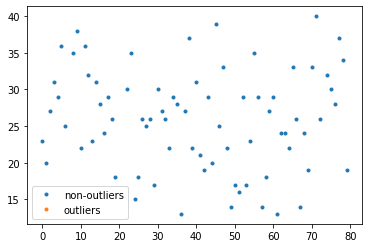

76 , 76


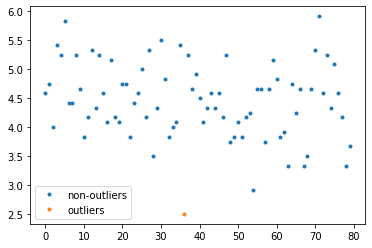

80 , 79


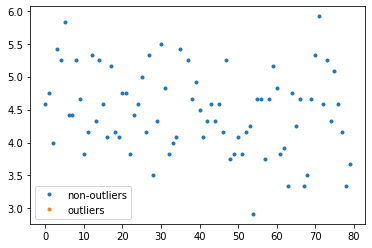

79 , 79


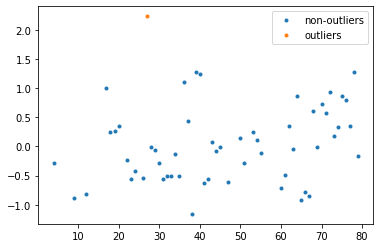

56 , 55


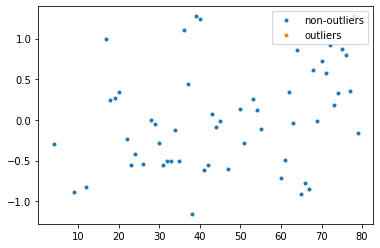

55 , 55


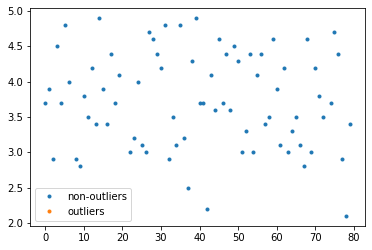

76 , 76


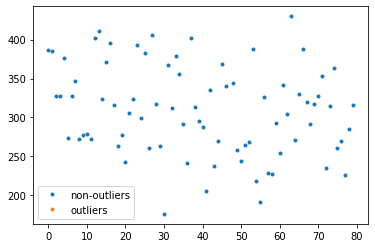

79 , 79


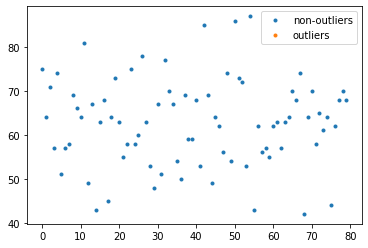

80 , 80


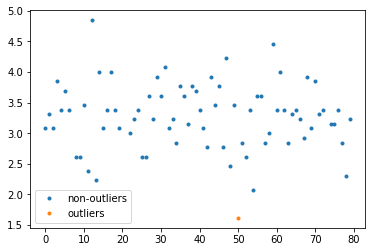

76 , 75


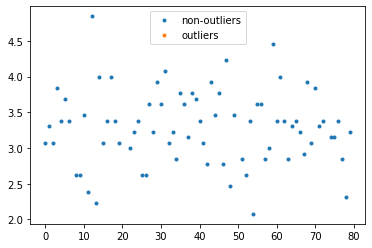

75 , 75


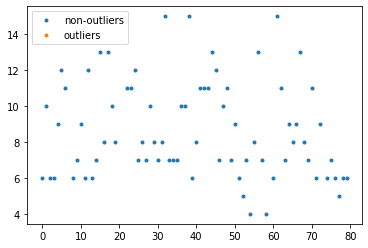

75 , 75


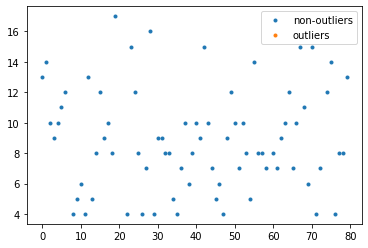

75 , 75


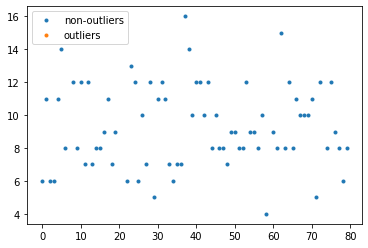

75 , 75


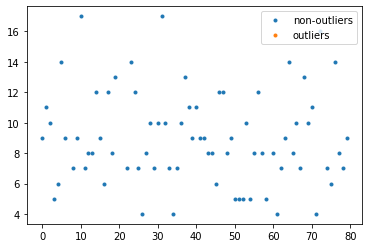

75 , 75


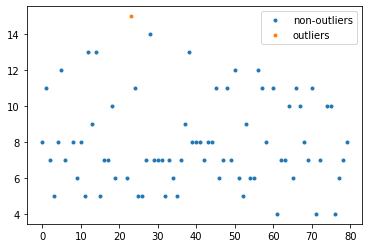

75 , 74


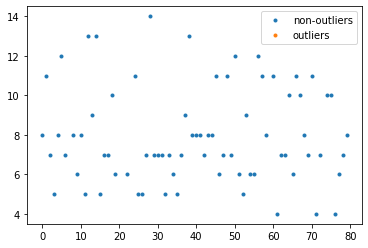

74 , 74


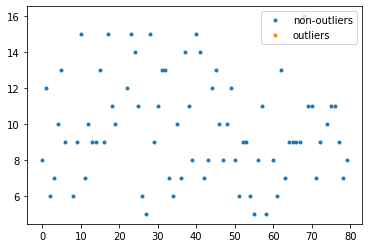

75 , 75


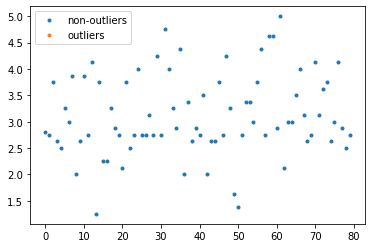

80 , 80


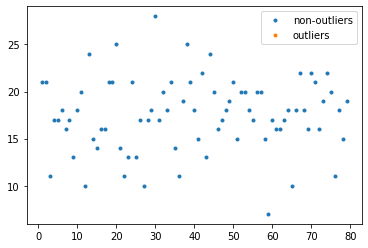

79 , 79


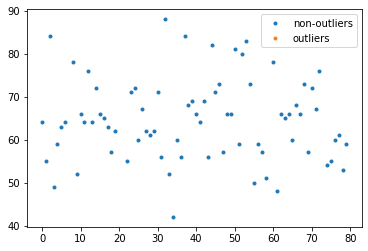

75 , 75


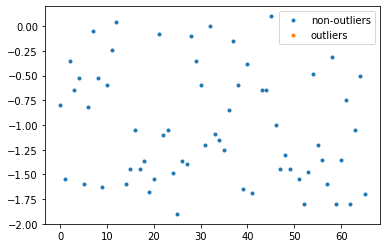

63 , 63


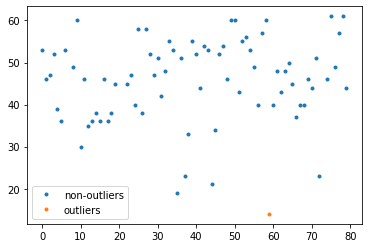

76 , 75


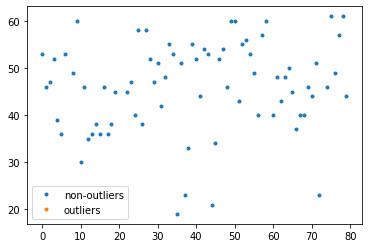

75 , 75


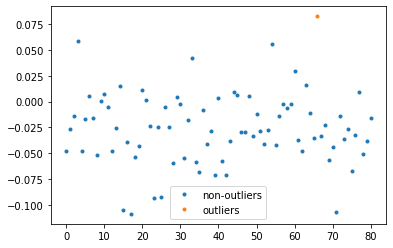

81 , 80


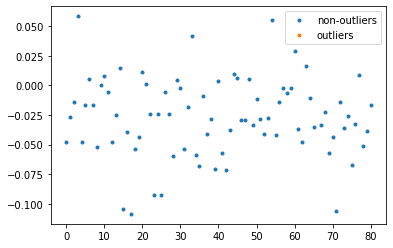

80 , 80


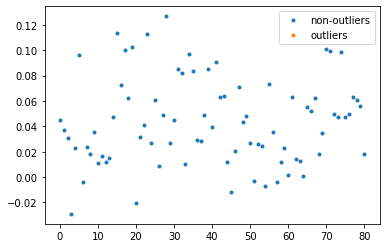

81 , 81


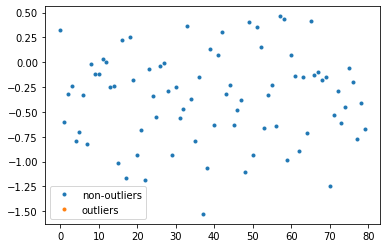

80 , 80


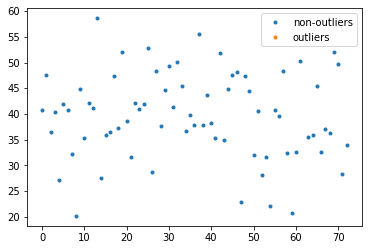

72 , 72


### CS_trials_CS_similarity

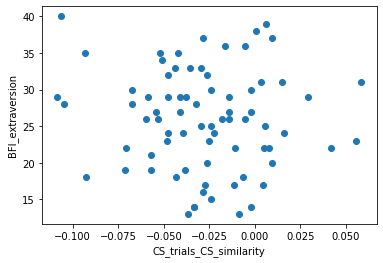

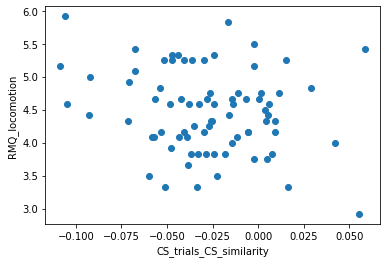

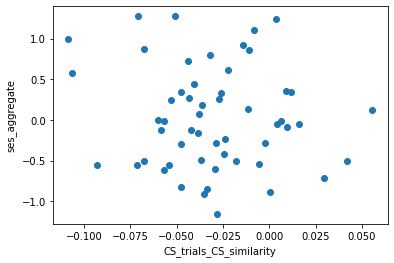

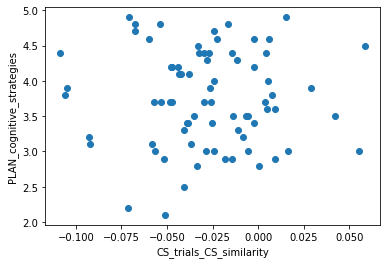

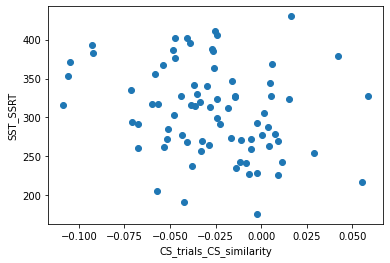

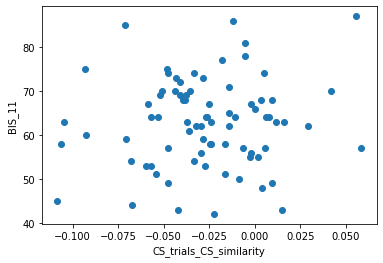

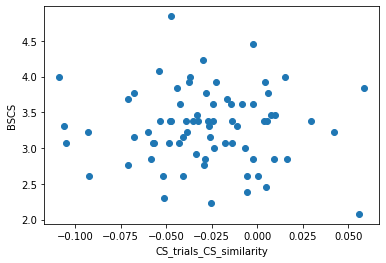

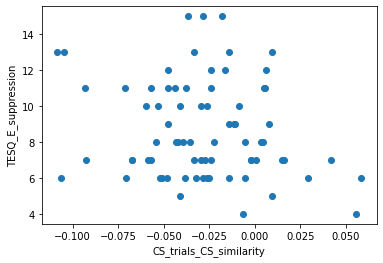

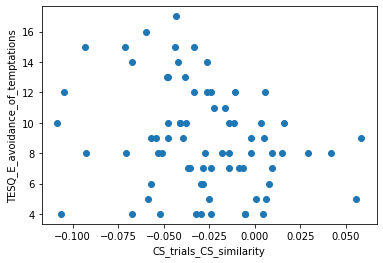

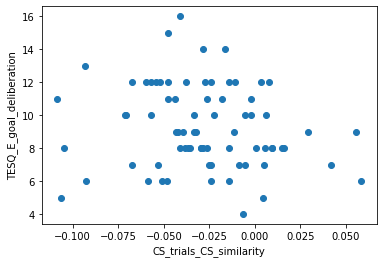

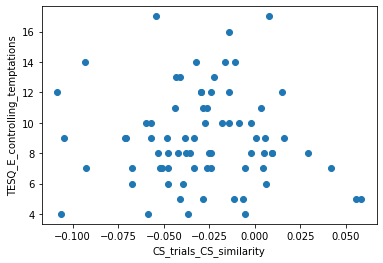

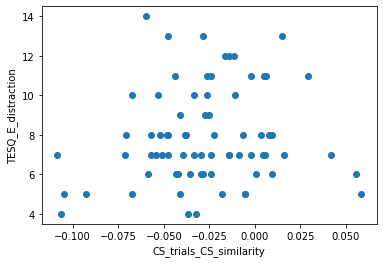

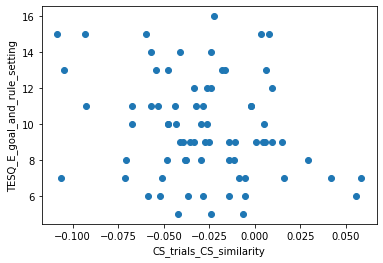

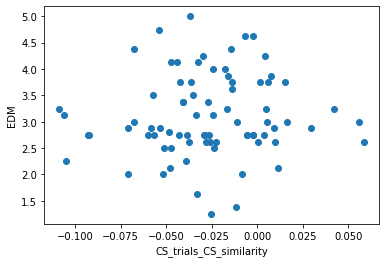

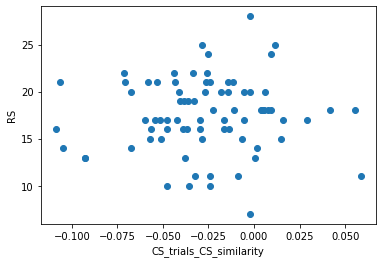

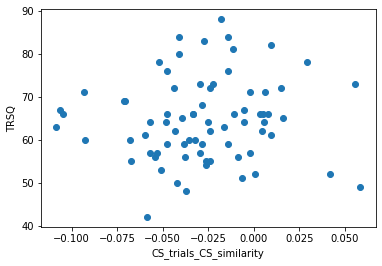

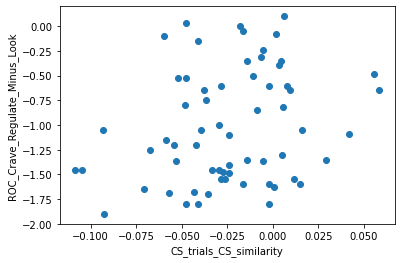

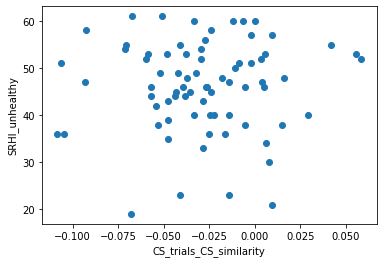

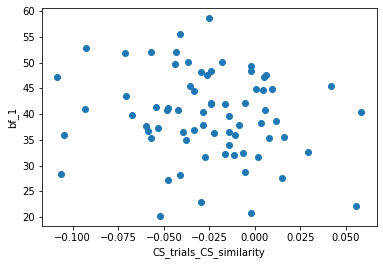

### CG_trials_CG_similarity

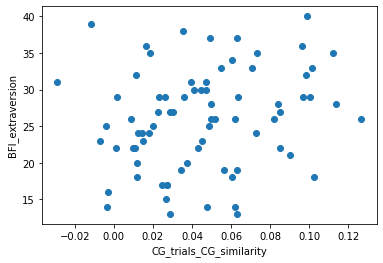

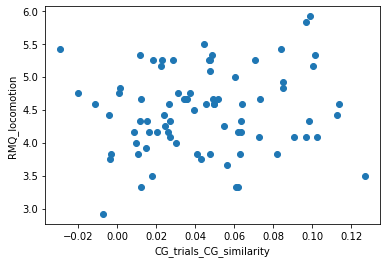

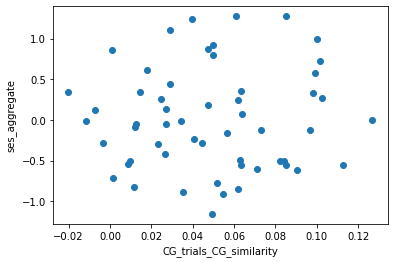

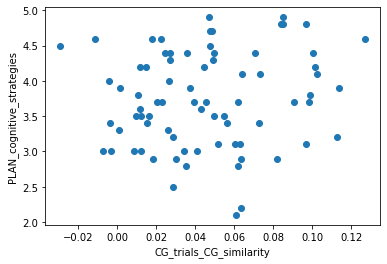

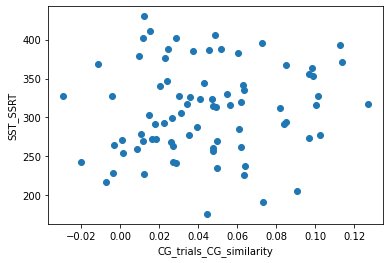

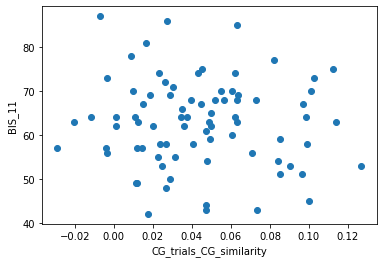

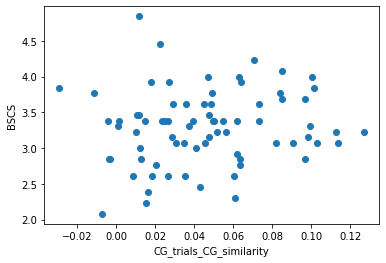

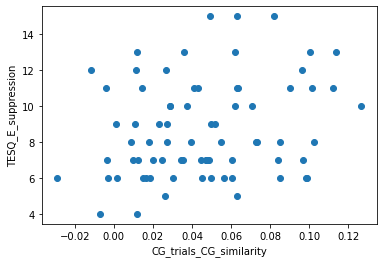

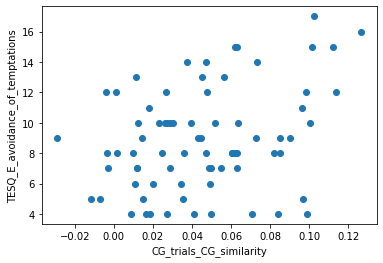

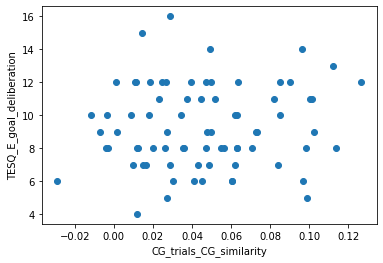

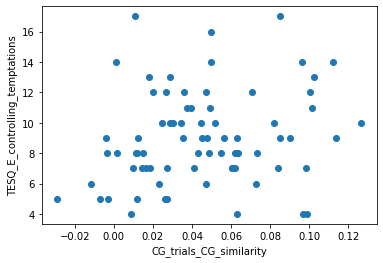

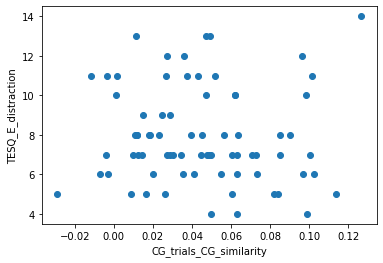

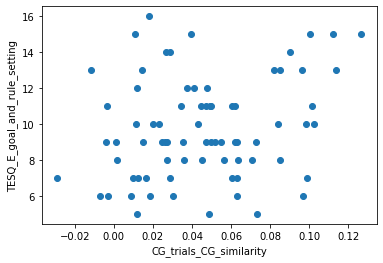

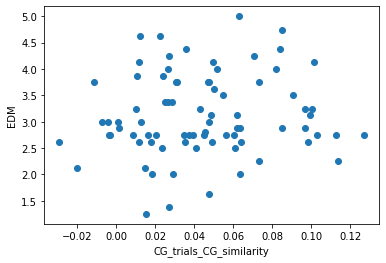

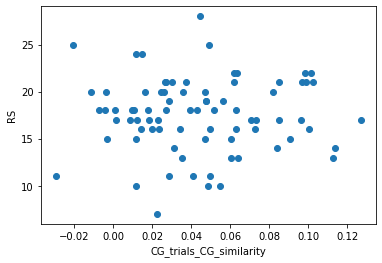

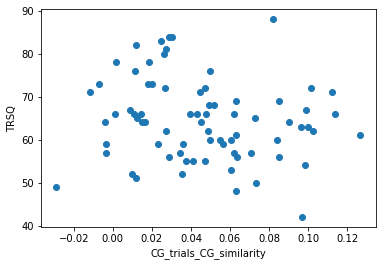

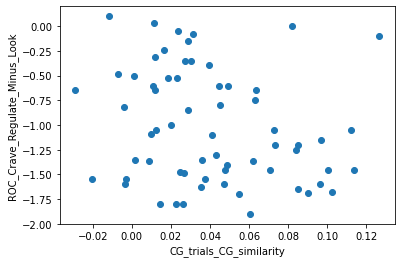

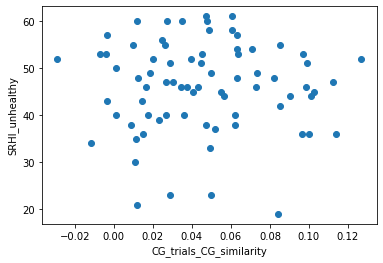

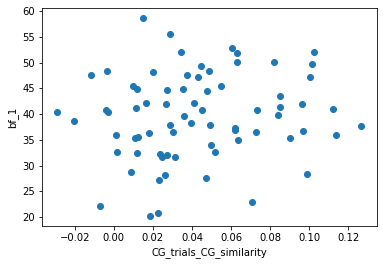

In [53]:
do_complete_analysis_for_mask('goal')